# code adapte from

code adpate from from code/MNF/notebooks/STRING_Data_11.5/deimos_identifyNovelPPI_phylumeffect_allEcoliPPI_visulization_fullHomologous_oneBestHomologousPP.ipynb

# load lib and set data 

In [2]:
import sys
import os 
from pathlib import Path
import pandas as pd
import numpy as np 
import copy 
import random
from random import shuffle
from collections import defaultdict
import itertools
import pickle
import glob
import re

import multiprocessing as mp 
import subprocess

import matplotlib.pyplot as plt 
import seaborn as sns

from Bio import AlignIO
from Bio import SeqIO
from Bio.Blast import NCBIXML


from Bio.PDB import PDBParser

import networkx as nx

from scipy.stats import ttest_ind

# import pkg_resources



In [3]:
%reload_ext autoreload
%autoreload 2



sys.path.append('../src/utilities/') # /mnt/mnemo5/tao/code/MNF/src/tao_utilities/,/home/cluster/tfang/MNF/src/tao_utilities/

from ROC_curve import DCA_RocCurve
from ROC_curve import Random_RocCurve
# from ROC_curve import Precison_Recall_RocCurve_OnIndepedentBenchmark
# from ROC_curve import Precison_Recall_RocCurve
from ROC_curve import Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark

# from Check_SameCogPair_problem import sepCogPairs_topDCAs_results


# # from IntergrateBestHomologousPPCoEvo_unNameSorted import getMetaFrame_withHighDCA


from IntergrateBestHomologousPPCoEvo_top5_unNameSorted import get_SubjectInfo_top5DCAs_FullBestHomologousPP
from IntergrateBestHomologousPPCoEvo_top5_unNameSorted import get_BestHomologousDCAs_top5DCAs_fromMultiSpes
# from IntergrateBestHomologousPPCoEvo_unNameSorted import sepCogPairs_FullBestHomologousPP_BestHomologousDCAs_uniquePhyla_ML_predictions

# from biasCheck import get_PPIwithTwoRibosomes_OnlyTest
# from biasCheck import isStringProIDs_Ribosome
# from biasCheck import isStringProIDs_oneRibosome
# from biasCheck import isStringProIDs_twoRibosome
# # from biasCheck import removeTrainPPfrom_allPredictionResults
# from biasCheck import KeepSameNegPP_removeOtherPPfrom_allPredictionResults
# from biasCheck import KeepCertainPPfrom_allPredictionResults
# from biasCheck import getAllIdxOf_fixed_negVSpos_ratio_keepCombination
# from biasCheck import getAllIdxOf_fixed_negVSpos_ratio_keepCombination_from_OriginalFrame
from biasCheck import removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio



from collect_topCoEvos import get_topRanking_CoEvo_file
# from collect_topCoEvos import sepCogPairs_ML_predictions_allTypeFeas


from coevolution_nomorlization import  get_idx2protein_dict
from coevolution_nomorlization import  get_proteinLevel_pairwise_matrix_full
from coevolution_nomorlization import proteinLevel_APC
# from coevolution_nomorlization import get_topRankingRecordsFromMatrix_list


from pdb_benchmark import get_STRING1105_pdb_interact
# from pdb_benchmark import add_pdbstatus_fromPureFrame  
from pdb_benchmark import add_pdbstatus

from STRING_benchmark import  get_STRING1105_physical_interact
from STRING_benchmark import  add_STRINGPhyPPI_status

# from OtherPPI_benchmark import get_QianCong_benchmark


from parse_AlphaFold_output import get_interprotein_contactprob_from_processedalphafoldnpz
from parse_AlphaFold_output import get_interprotein_maxcontactprob_from_processedalphafoldnpz
from parse_AlphaFold_output import get_interprotein_mincm_from_pdb
from parse_AlphaFold_output import get_ptm_from_scoreFile

from plotting_utilities import check_PPIDist_inGraph

In [7]:
notebookData_folder="/mnt/mnemo6/tao/notebook_data/"  #"/mnt/mnemo6/tao/"

In [8]:
colab_outputPath=notebookData_folder+"colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve1224/"

In [9]:
Query_tuple=('1224', '511145')
Subject_tupleList=[("1239","1274374"),('201174', '105422'), ('976', '411476'),] #[('1224', '287'),("1239","1274374"),('201174', '105422'), ('976', '411476'),]


In [10]:
CoEvo_data_folder=notebookData_folder+"PPI_Coevolution/CoEvo_data_STRING11.5/" #"/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/",/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/
Query_input_root_folder=CoEvo_data_folder+"allPPI_"+Query_tuple[1]+"_EggNOGmaxLevel"+Query_tuple[0]+"_eggNOGfilteredData/"
Query_Benchmark_folder=Query_input_root_folder+"AllPPI_Benchmark/"
Query_ML_inputPath=Query_Benchmark_folder+"ML_inputs/"

Query_DCA_coevolutoin_path=Query_input_root_folder+"coevolutoin_result_DCA/"

print(f"Query_Benchmark_folder:{Query_Benchmark_folder}")
print(f"Query_DCA_coevolutoin_path:{Query_DCA_coevolutoin_path}")


Query_Benchmark_folder:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/AllPPI_Benchmark/
Query_DCA_coevolutoin_path:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/coevolutoin_result_DCA/


In [11]:
if not os.path.exists(Query_Benchmark_folder):
    os.makedirs(Query_Benchmark_folder)


In [12]:
Query_Benchmark_folder

'/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/AllPPI_Benchmark/'

In [16]:

pdb_interact_PPs,pdb_complex_PPs=get_STRING1105_pdb_interact(pdb_interact_filename=notebookData_folder+"STRING_derived_v11.5/pdb/pdb_interact.tsv",
                                retrieve_spe=511145,)



pdb_interact_PPs_dict={pp: 1 for pp in pdb_interact_PPs}
pdb_complex_PPs_dict={pp: 1 for pp in pdb_complex_PPs}
pdb_PPs_dict={pp: 1 for pp in pdb_interact_PPs+pdb_complex_PPs}

print(len(pdb_interact_PPs),len(pdb_complex_PPs),len(pdb_PPs_dict))


print(len(set(pdb_interact_PPs).intersection(pdb_complex_PPs)))

print(len(set(pdb_interact_PPs).union(pdb_complex_PPs)))

len of intersection: 309
414 3243 3657
0
3657


In [17]:
STRINGcurrentSpeAllPhyPPI_posPPI_dict=get_STRING1105_physical_interact(data_folder=notebookData_folder+"STRING_derived_v11.5/download_files/protein.physical.links.v11.5/",
                                retrieve_spe=511145,
                                combined_score_thres=0)
print(len(STRINGcurrentSpeAllPhyPPI_posPPI_dict))

STRINGcurrentSpePhyPPI_posPPI_dict=get_STRING1105_physical_interact(data_folder=notebookData_folder+"STRING_derived_v11.5/download_files/protein.physical.links.v11.5/",
                                retrieve_spe=511145,
                                combined_score_thres=500)
print(len(STRINGcurrentSpePhyPPI_posPPI_dict))




STRINGcurrentSpePhyPPI_benchmark.shape: (53300, 3)
STRINGcurrentSpePhyPPI_benchmark.shape: (53300, 3)
53300
STRINGcurrentSpePhyPPI_benchmark.shape: (53300, 3)
STRINGcurrentSpePhyPPI_benchmark.shape: (15476, 3)
15476


In [18]:

# read protein name file 
ecoli_proteinNames=pd.read_csv(notebookData_folder+"PPI_Coevolution/STRING_data_11.5/511145.protein.info.v11.5.txt.gz",
                            #"/mnt/mnemo5/tao/STRING/511145.protein.info.v11.0.txt",
                              header=0,index_col=None, sep="\t")


print(ecoli_proteinNames.shape)
#ecoli_proteinNames.head(n=3)

#ecoli_proteinNames_dict=dict(ecoli_proteinNames.loc[:,["protein_external_id","preferred_name"]].values.tolist())
ecoli_proteinNames_dict=dict(ecoli_proteinNames.loc[:,["#string_protein_id","preferred_name"]].values.tolist())

ecoli_proteinNames.head(n=3)


(4127, 4)


,#string_protein_id,preferred_name,protein_size,annotation
0,511145.b0001,thrL,21,This protein is involved in control of the bio...
1,511145.b0002,thrA,820,In the C-terminal section; belongs to the homo...
2,511145.b0003,thrB,310,Catalyzes the ATP-dependent phosphorylation of...


In [21]:
%%time 
# this is a reversed file alread :(p1,p2),(p2,p1)
Ecoli_string_score_filename=notebookData_folder+"PPI_Coevolution/STRING_data_11.5/511145.protein.links.detailed.v11.5.txt.gz"

Ecoli_string_score=pd.read_csv(Ecoli_string_score_filename,
                               header=0,index_col=None,sep=" ")
Ecoli_string_score_list=Ecoli_string_score.loc[:,["protein1","protein2","combined_score"]].values.tolist()
Ecoli_string_score_dict=dict([((p1,p2),s)for p1, p2, s in Ecoli_string_score_list])

print(Ecoli_string_score.shape)

(1083186, 10)
CPU times: user 1.73 s, sys: 110 ms, total: 1.84 s
Wall time: 1.85 s


In [22]:
Ecoli_string_score_filename

'/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/STRING_data_11.5/511145.protein.links.detailed.v11.5.txt.gz'

# benchmark data preparation 


## for Query species 

In [27]:
# %%time 

#skip this step if you dont generetate all DCA results 
if not os.path.exists(Query_Benchmark_folder+"allPPI_allInfo_frame.csv"):
    Query_existed_pydcaFNAPC_files=glob.glob(Query_DCA_coevolutoin_path+"*_pydcaFNAPC_array.npz")
    print(len(Query_existed_pydcaFNAPC_files))
    print(Query_existed_pydcaFNAPC_files[0:3])

    Query_existed_pydcaFNAPC_files=[os.path.basename(f) for f in Query_existed_pydcaFNAPC_files]
    Query_existed_pydcaFNAPC_pps=[f.split("and") for f in Query_existed_pydcaFNAPC_files]
    Query_existed_pydcaFNAPC_pps=[(p1,p2[:-21]) for p1, p2 in Query_existed_pydcaFNAPC_pps]

    newSTRING_rootFolder="/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/STRING_data_11.5/"
    Query_currentSpeMiddleDataPath=newSTRING_rootFolder+Query_tuple[1]+"_EggNOGmaxLevel"+Query_tuple[0]+"_MiddleData/"
    with open(Query_currentSpeMiddleDataPath+'fasta_protein_lens_dict.pickle', 'rb') as handle:
        Query_fasta_protein_lens=pickle.load(handle) 

    Query_existed_pydcaFNAPC_pps_info=[[p1,p2,Query_fasta_protein_lens[p1],Query_fasta_protein_lens[p2]] for p1 , p2 in Query_existed_pydcaFNAPC_pps]
    print("len(Query_existed_pydcaFNAPC_pps_info):",len(Query_existed_pydcaFNAPC_pps_info))

    print("Query_existed_pydcaFNAPC_pps_info[0:3]:",Query_existed_pydcaFNAPC_pps_info[0:3])

    Query_allPPI_allInfo_frame=pd.DataFrame(Query_existed_pydcaFNAPC_pps_info,
                                        columns=["STRING_ID1","STRING_ID2","len1","len2"]
                                            )
    Query_allPPI_allInfo_frame.head(n=3)


    Query_allPPI_allInfo_frame.to_csv(Query_Benchmark_folder+"allPPI_allInfo_frame.csv",header=True,index=None,sep="\t")



In [13]:

# Query_allPPI_allInfo_frame=pd.read_csv(Query_Benchmark_folder+"allPPI_allInfo_frame.csv",
#                                  header=0,index_col=None,sep="\t")
# print(Query_allPPI_allInfo_frame.shape)
# Query_allPPI_allInfo_frame.head(n=3)

In [14]:
# Query_existed_pydcaFNAPC_pps_info=Query_allPPI_allInfo_frame.values.tolist()


## for Subject species 

In [30]:
# %%time 
# skip this step if you dont regenerated all raw date from scratch

# newSTRING_rootFolder="/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/STRING_data_11.5/"

for currentSubject_EggNOG_maxLevel ,  currentSubject_TaxID in Subject_tupleList[0:3]:
    print("*****************************")

    input_root_folder=CoEvo_data_folder+currentSubject_TaxID+"_EggNOGmaxLevel"+currentSubject_EggNOG_maxLevel+"_eggNOGfilteredData/"
    currentSubject_DCA_coevolutoin_path=input_root_folder+"coevolutoin_result_DCA/"

    Subect_prefix="BestHomologousPPFor"+Query_tuple[1]+"AtEggNOGmaxLevel"+Query_tuple[0]+"_"
    
    Benchmark_folder=input_root_folder+Subect_prefix+"STRINGPhyBalancePhyla_Benchmark/" # this read infomation of all ppi homologous pp,which is get from 
    # #http://localhost:8206/lab/workspaces/auto-n/tree/code/MNF/notebooks/STRING_Data_11.5/Compute_allPPI_homologousPPDetection.ipynb
    print(f"Benchmark_folder:{Benchmark_folder}")
    
    Current_Subject_Benchmark_folder=input_root_folder+Subect_prefix+"AllPPI_Benchmark/" # this is benchmark for all ppi homologous pp
    print(f"Current_Subject_Benchmark_folder:{Current_Subject_Benchmark_folder}")
    
    if not os.path.exists(Current_Subject_Benchmark_folder):
        os.makedirs(Current_Subject_Benchmark_folder)


        currentSubjectMiddleDataPath=newSTRING_rootFolder+currentSubject_TaxID+"_EggNOGmaxLevel"+currentSubject_EggNOG_maxLevel+"_MiddleData/"    
        print(currentSubjectMiddleDataPath)

        with open(currentSubjectMiddleDataPath+'fasta_protein_lens_dict.pickle', 'rb') as handle:
            currentSubject_fasta_protein_lens=pickle.load(handle)

        print(len(currentSubject_fasta_protein_lens))
        print(list(currentSubject_fasta_protein_lens.items())[0:3])


        Current_Subject_homologousPPs_beforeDCAcomputation_file=Benchmark_folder+"Current_Subject_BestHomologousPPs_beforeDCAcomputation.pickle"
        with open(Current_Subject_homologousPPs_beforeDCAcomputation_file, 'rb') as handle:
                Current_Subject_homologousPPs=pickle.load(handle)
        print("len(Current_Subject_homologousPPs):",len(Current_Subject_homologousPPs))
        print(Current_Subject_homologousPPs[0:3])

        # this step can be omit, keep here just for checking 
        currentSubject_existed_pydcaFNAPC_files=glob.glob(currentSubject_DCA_coevolutoin_path+"*_pydcaFNAPC_array.npz")
        print("len(currentSubject_existed_pydcaFNAPC_files):",len(currentSubject_existed_pydcaFNAPC_files))
        print(currentSubject_existed_pydcaFNAPC_files[0:3])

        Current_Subject_homologousPPs_info=[[p1,p2,currentSubject_fasta_protein_lens[p1],currentSubject_fasta_protein_lens[p2]] for p1 , p2 in Current_Subject_homologousPPs ]
        print("len(Current_Subject_homologousPPs_info):",len(Current_Subject_homologousPPs_info))

        print("Current_Subject_homologousPPs_info[0:3]:",Current_Subject_homologousPPs_info[0:3])

        Current_Subject_homologousPPs_info_frame=pd.DataFrame(Current_Subject_homologousPPs_info,
                                            columns=["STRING_ID1","STRING_ID2","len1","len2"]
                                                )
        Current_Subject_homologousPPs_info_frame.head(n=3)


        Current_Subject_homologousPPs_info_frame.to_csv(Current_Subject_Benchmark_folder+"BestHomologousPP_allPPI_allInfo_frame.csv",header=True,index=None,sep="\t")

    



*****************************
Benchmark_folder:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_STRINGPhyBalancePhyla_Benchmark/
Current_Subject_Benchmark_folder:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/
*****************************
Benchmark_folder:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/105422_EggNOGmaxLevel201174_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_STRINGPhyBalancePhyla_Benchmark/
Current_Subject_Benchmark_folder:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/105422_EggNOGmaxLevel201174_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/
*****************************
Benchmark_folder:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoE

# prepare best homologous protein pp 

In [47]:
%%time 
with open(notebookData_folder+"PPI_Coevolution/STRING_data_11.5/511145_EggNOGmaxLevel1224_allQuery2SubjectPPIMapping/NameUnsorted_Query2Subject_QueSpeAllPPI_homologous_dict_listDict.pickle", 'rb') as handle:
        Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict=pickle.load(handle)
        


CPU times: user 2.41 s, sys: 504 ms, total: 2.91 s
Wall time: 3.15 s


In [48]:
for _,t_dict in Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict.items():
    print(_)
    print(len(t_dict))
    count=0
    for v in t_dict.values():
        count += len(v)
    print(count,count/2)

('1239', '1274374')
1510551
3021102 1510551.0
('201174', '105422')
1598711
3197422 1598711.0
('976', '411476')
1229632
2459264 1229632.0
('2', '179408')
1269201
2538402 1269201.0


In [49]:
Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict={k:v for k,v in Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict.items() if k in Subject_tupleList }

Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict.keys()

dict_keys([('1239', '1274374'), ('201174', '105422'), ('976', '411476')])

In [50]:
list(Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict[('1239', '1274374')].items())[0]



(('511145.b0003', '511145.b0004'),
 ('1274374.CBLK010000071_gene1043', '1274374.CBLK010000070_gene1131'))

# STRING 11.5, phylum 1224, species 511145

In [51]:

Query_allPPI_allInfo_frame=pd.read_csv(Query_Benchmark_folder+"allPPI_allInfo_frame.csv",
                                 header=0,index_col=None,sep="\t")
print(Query_allPPI_allInfo_frame.shape)
Query_allPPI_allInfo_frame.head(n=3)

(2269192, 4)


,STRING_ID1,STRING_ID2,len1,len2
0,511145.b2547,511145.b4214,494,243
1,511145.b1913,511145.b3965,600,363
2,511145.b1771,511145.b2074,310,399


In [52]:
%%time 

Query_allPPI_info=Query_allPPI_allInfo_frame.loc[:,["STRING_ID1","STRING_ID2","len1","len2"]].values.tolist()

Query_allPPI_allInfo_dict=dict([((p1,p2),(len1,len2)) for p1,p2,len1,len2 in Query_allPPI_info])


# CPU times: user 2.1 s, sys: 361 ms, total: 2.46 s
# Wall time: 15.1 s


CPU times: user 6.69 s, sys: 550 ms, total: 7.24 s
Wall time: 7.24 s


In [53]:
Query_topRanking_DCA_file=Query_Benchmark_folder+"DCA_thres_"+str(0)+"_topRanking_pydcaFNAPC_frame.csv" 
print(Query_topRanking_DCA_file)


/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/AllPPI_Benchmark/DCA_thres_0_topRanking_pydcaFNAPC_frame.csv


In [23]:
Query_Benchmark_folder

'/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/AllPPI_Benchmark/'



module load hpc
conda activate py37_base
sbatch  /home/cluster/tfang/MNF/notebooks/ScienceCluster_code/STRING_Data_11.5/collect_allPPI_topDCAs.sh




In [55]:
%%time 

#if already run in in batch format, here dont need to recollect and rewrite results but just read alreayd saved results ?

Query_top_DCA_dict=get_topRanking_CoEvo_file(topRanking_CoEvo_file=Query_topRanking_DCA_file,
                                               coevolutoin_path=Query_DCA_coevolutoin_path,
                                               coevo_suffix="_pydcaFNAPC_array",
                                               allPPI_info=Query_allPPI_info, #, # [0:3] ,[0:1000],[0:10000]
                                               returnDic=True,
#                                                overwrite=True,
                                            overwrite=False,
                                            use_multiprocessing=10#False
                                              )

# top_CoEvo_frame.shape: (2269192, 152)
# sys.getsizeof(top_CoEvo_list)/(1024*1024*1024):0.016906864941120148
# CPU times: user 1min 21s, sys: 2min 48s, total: 4min 10s
# Wall time: 6min 3s


top_CoEvo_frame.shape: (2269192, 152)
sys.getsizeof(top_CoEvo_list)/(1024*1024*1024):0.016906864941120148
CPU times: user 59.9 s, sys: 21.1 s, total: 1min 21s
Wall time: 1min 53s


In [57]:
%%time
Query_top_DCA_top5DCAs_dict={pp:[v[3*i] for i in range(5)] for pp, v in Query_top_DCA_dict.items()}


CPU times: user 14.1 s, sys: 410 ms, total: 14.5 s
Wall time: 14.5 s


In [58]:
print(sys.getsizeof(Query_top_DCA_top5DCAs_dict)/(1024*1024*1024))

0.07812509685754776


In [59]:
Query_top_DCA_top5DCAs_dict[('511145.b2547', '511145.b4214')]

[0.7821, 0.7538, 0.7246, 0.7084, 0.6774]

# For Ecoli 11.5, get its top 5 DCA score from its BestHomologous pp from other speceis 



In [63]:
%%time 
#if already run in in batch format, here dont need to recollect and rewrite results but just read alreayd saved results ?
BestHomologousPP_top5DCAs_Subject_allPPI_allInfo_dict_listDict=get_SubjectInfo_top5DCAs_FullBestHomologousPP(Query_tuple,
                                      Subject_tupleList,
                                      STRING_version="11.5",
                                    coevo_suffix="_pydcaFNAPC_array",
                                      benchmark_suffix="AllPPI_Benchmark/",
                                    CoEvo_data_folder=CoEvo_data_folder,
                                      topDCA_num=5,
                                       returnDic=True,
#                                         overwrite=True,
                                        overwrite=False,
                                        #use_multiprocessing=False,
                                        use_multiprocessing=20,   #10,                                                     
                                            )



# 201174 105422 , raw date processing time 
# BestHomologousPP_Benchmark_folder: /net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/105422_EggNOGmaxLevel201174_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/
# allPPI_allInfo_frame.shape: (634253, 4)
# BestHomologousPP_Benchmark_folder:/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/105422_EggNOGmaxLevel201174_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/
# DCA_coevolutoin_path:/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/105422_EggNOGmaxLevel201174_eggNOGfilteredData/coevolutoin_result_DCA/
# topRanking_pydcaFNAPC_file:/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/105422_EggNOGmaxLevel201174_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/BestHomologousPP_topRanking_pydcaFNAPC_frame.csv
# topRanking_CoEvo_file: /net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/105422_EggNOGmaxLevel201174_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/BestHomologousPP_topRanking_pydcaFNAPC_frame.csv
# top_CoEvo_frame.shape: (634253, 152)
# len(top_pydcaFNAPC_dict): 634253
# len(Subject_allPPI_allInfo_dict): 634253
# CPU times: user 2min 43s, sys: 7min 21s, total: 10min 5s
# Wall time: 2h 26min 13s


# 201174 105422 , time of only read data 
# around 1 minutes 


1239 1274374
BestHomologousPP_Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/
allPPI_allInfo_frame.shape: (513280, 4)
BestHomologousPP_Benchmark_folder:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/
DCA_coevolutoin_path:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/coevolutoin_result_DCA/
topRanking_pydcaFNAPC_file:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/BestHomologousPP_topRanking_pydcaFNAPC_frame.csv
top_CoEvo_frame.shape: (513280, 152)
sys.getsizeof(top_CoEvo_list)/(1024*1024*1024):0.003824301064014435
len(t

In [64]:
BestHomologousPP_top5DCAs_Subject_allPPI_allInfo_dict_listDict.keys()

dict_keys([('1239', '1274374'), ('201174', '105422'), ('976', '411476')])

In [65]:
list(BestHomologousPP_top5DCAs_Subject_allPPI_allInfo_dict_listDict[('1239', '1274374')].items())[0] 


(('1274374.CBLK010000064_gene892', '1274374.CBLK010000065_gene1568'),
 [1.0909, 0.7794, 0.7737, 0.7638, 0.6774])

In [66]:
Query_allPPI_allInfo_dict[('511145.b2547', '511145.b4214')],Query_top_DCA_top5DCAs_dict[('511145.b2547', '511145.b4214')]


((494, 243), [0.7821, 0.7538, 0.7246, 0.7084, 0.6774])

In [67]:
%%time 
Query_BestHomologousDCAs_top5DCAs_dict=get_BestHomologousDCAs_top5DCAs_fromMultiSpes(Query_allPPI_allInfo_dict=Query_allPPI_allInfo_dict,
                                    Query_allPPI_top5DCAs_dict=Query_top_DCA_top5DCAs_dict,
                                    BestHomologousPP_Subject_allPPI_top5DCAs_listDict=BestHomologousPP_top5DCAs_Subject_allPPI_allInfo_dict_listDict,
                                    Query2Subject_BestHomologous_ignoreSubjectDCA_dict_listDict=Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict,
                                        topDCA_num=5,
                                    with_status=False)

# CPU times: user 46.1 s, sys: 632 ms, total: 46.7 s
# Wall time: 4min 39s

CPU times: user 28.2 s, sys: 1.36 s, total: 29.6 s
Wall time: 29.6 s


In [68]:
print(len(Query_BestHomologousDCAs_top5DCAs_dict))

2269192


In [69]:
print(list(Query_BestHomologousDCAs_top5DCAs_dict.items())[0])

(('511145.b2547', '511145.b4214'), [0.7821, 0.7538, 0.7246, 0.7084, 0.6774, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])


### train  large STRINGPhyBalancePhyla ml dataset and model 

check test_withLowDCA_phylumeffect_STRINGFullPhyBalancePhyla_visulization_fullHomologous_oneBestHomologousPP.ipynb

# prepare data to be use by machine leanring model 


In [70]:
%%time
Query_maxDCAs=[v[0] for k, v in Query_top_DCA_top5DCAs_dict.items()]
Query_PPs=[k for k, v in Query_top_DCA_top5DCAs_dict.items()]

CPU times: user 329 ms, sys: 15.2 ms, total: 344 ms
Wall time: 343 ms


In [36]:
len(Query_PPs)

2269192

In [71]:
%%time
Query_BestHomologousDCAs_top5DCAs_PPs=[k for k, v in Query_BestHomologousDCAs_top5DCAs_dict.items()]
Query_BestHomologousDCAs_top5DCAs_npArray=np.array([v for k, v in Query_BestHomologousDCAs_top5DCAs_dict.items()])
Query_BestHomologousDCAs_top5DCAs_npArray[np.isnan(Query_BestHomologousDCAs_top5DCAs_npArray)]=-1
Query_BestHomologousDCAs_top5DCAs_npArray.shape

CPU times: user 6.37 s, sys: 102 ms, total: 6.47 s
Wall time: 6.47 s


(2269192, 20)

In [72]:
max(np.sum(Query_BestHomologousDCAs_top5DCAs_npArray==-1,axis=1))

15

In [73]:
Query_BestHomologousDCAs_top5DCAs_maxDCAs=np.max(Query_BestHomologousDCAs_top5DCAs_npArray,axis=1)
Query_BestHomologousDCAs_top5DCAs_maxDCAs.shape



(2269192,)

In [74]:
Query_BestHomologousDCAs_top5DCAs_maxDCAs_dict={Query_BestHomologousDCAs_top5DCAs_PPs[i]:Query_BestHomologousDCAs_top5DCAs_maxDCAs[i] for i in range(len(Query_BestHomologousDCAs_top5DCAs_PPs))}

In [75]:
%%time
all([Query_PPs[i]==Query_BestHomologousDCAs_top5DCAs_PPs[i] for i in range(len(Query_PPs))])


CPU times: user 509 ms, sys: 8.03 ms, total: 517 ms
Wall time: 517 ms


True

In [76]:
%%time
Query_maxDCAs_maxDCAofAllPhylum_frame=pd.DataFrame([(Query_PPs[i][0],Query_PPs[i][1],Query_maxDCAs[i],Query_BestHomologousDCAs_top5DCAs_maxDCAs[i]) for i in range(len(Query_PPs))],
                                                      columns=["p1","p2","maxDCA","maxDCAofAllPhylum"])

Query_maxDCAs_maxDCAofAllPhylum_frame=add_STRINGPhyPPI_status(Query_maxDCAs_maxDCAofAllPhylum_frame,STRINGcurrentSpePhyPPI_posPPI_dict)

Query_maxDCAs_maxDCAofAllPhylum_frame=add_pdbstatus(Query_maxDCAs_maxDCAofAllPhylum_frame,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )

print(Query_maxDCAs_maxDCAofAllPhylum_frame.shape)

Query_maxDCAs_maxDCAofAllPhylum_frame_longformat= pd.melt(Query_maxDCAs_maxDCAofAllPhylum_frame, 
                                                            id_vars='pdb_status', 
                                                            value_vars=[f"maxDCA",f"maxDCAofAllPhylum"])



print(Query_maxDCAs_maxDCAofAllPhylum_frame_longformat.shape)


(2269192, 6)
(4538384, 3)
CPU times: user 25.7 s, sys: 2.05 s, total: 27.7 s
Wall time: 27.7 s


#  use new full  STRINGPhyBalancePhyla  phylum integration machine leanrin model 

In [ ]:
stop here, as reuslt from here can be generege from other notebook, maybe i dont need to mannuyl move data here 


In [43]:


#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
#ML_folder="/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/"
STRINGFullPhyBalancePhyla_Benchmark_folder="/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/"


#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
with open(os.path.join(STRINGFullPhyBalancePhyla_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_LR.pickle"),"rb") as f:
    STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_LR_bestModel=pickle.load(f)
    
    
    
#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
with open(os.path.join(STRINGFullPhyBalancePhyla_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_RF.pickle"),"rb") as f:
    STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_RF_bestModel=pickle.load(f)
    
    
    
with open(os.path.join(STRINGFullPhyBalancePhyla_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs.pickle"),"rb") as f:
    STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs=pickle.load(f)
    
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs=\
{pp:1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs}
    
print(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_RF_bestModel.get_params())
    

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {1: 10}, 'criterion': 'gini', 'max_depth': 8, 'max_features': 2, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [44]:
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_allPPI_allInfo_frame=pd.read_csv(\
os.path.join("/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_allPPI_allInfo_frame.csv"),
header=0,index_col=None)



In [45]:
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs))



73491


In [46]:
%%time 
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_LR_bestModel.predict_proba(Query_BestHomologousDCAs_top5DCAs_npArray)[:,1]


# CPU times: user 1.43 s, sys: 4.96 s, total: 6.39 s
# Wall time: 89.6 ms

CPU times: user 995 ms, sys: 2 s, total: 3 s
Wall time: 52.6 ms


In [47]:
%%time 
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_RF_bestModel.predict_proba(Query_BestHomologousDCAs_top5DCAs_npArray)[:,1]

# CPU times: user 2min 51s, sys: 3.58 s, total: 2min 54s
# Wall time: 2min 54s

CPU times: user 1min 5s, sys: 8.84 s, total: 1min 14s
Wall time: 17.4 s


In [48]:
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_dict={pp:STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[idx] for idx,pp in enumerate(Query_BestHomologousDCAs_top5DCAs_PPs)}



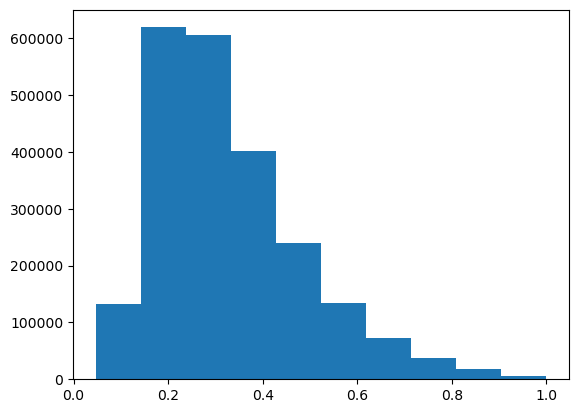

In [49]:
plt.hist(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results)
plt.show()

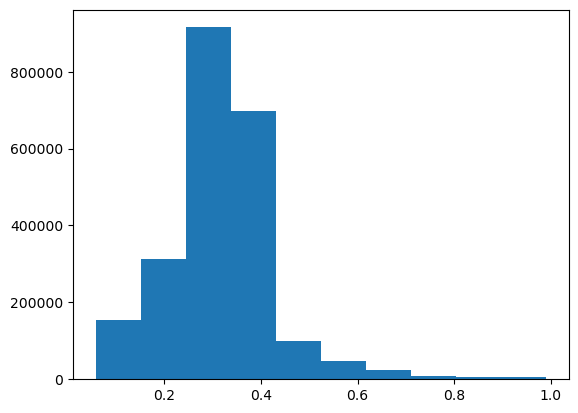

In [50]:
plt.hist(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results)
plt.show()

In [51]:
%%time
STRINGFullPhyBalancePhyla_LRandRF_frame=pd.DataFrame([(Query_PPs[i][0],Query_PPs[i][1],STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results[i],STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[i]) for i in range(len(Query_PPs))],
                                                      columns=["p1","p2","LR","RF"])

STRINGFullPhyBalancePhyla_LRandRF_frame=add_STRINGPhyPPI_status(STRINGFullPhyBalancePhyla_LRandRF_frame,STRINGcurrentSpePhyPPI_posPPI_dict)

STRINGFullPhyBalancePhyla_LRandRF_frame=add_pdbstatus(STRINGFullPhyBalancePhyla_LRandRF_frame,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )


print(STRINGFullPhyBalancePhyla_LRandRF_frame.shape)
# Query_LRandRF_frame.to_csv(Query_Benchmark_folder+"Ecoli_LRandRF_frame.csv",
#                             header=True,index=None,sep="\t")




(2269192, 6)
CPU times: user 11.1 s, sys: 739 ms, total: 11.8 s
Wall time: 11.7 s


#### saeve all2all results 

In [52]:


STRINGFullPhyBalancePhyla_DCAandLRandRF_frame=pd.DataFrame([(Query_PPs[i][0],Query_PPs[i][1],Query_maxDCAs[i],STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results[i],STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[i]) for i in range(len(Query_PPs))],
                                                      columns=["p1","p2","maxDCA","LR","RF"])

STRINGFullPhyBalancePhyla_DCAandLRandRF_frame=add_STRINGPhyPPI_status(STRINGFullPhyBalancePhyla_DCAandLRandRF_frame,STRINGcurrentSpePhyPPI_posPPI_dict)

STRINGFullPhyBalancePhyla_DCAandLRandRF_frame=add_pdbstatus(STRINGFullPhyBalancePhyla_DCAandLRandRF_frame,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )


STRINGFullPhyBalancePhyla_DCAandLRandRF_frame.to_csv("/mnt/mnemo5/tao/temp_figures/STRINGFullPhyBalancePhyla_DCAandLRandRF_frame.csv",
                                                    sep="\t",header=True,index=None)

print(STRINGFullPhyBalancePhyla_DCAandLRandRF_frame.shape)

(2269192, 7)


In [53]:
%%time
STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP=pd.DataFrame([(Query_PPs[i][0],Query_PPs[i][1],STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results[i],STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[i]) for i in range(len(Query_PPs)) if (Query_PPs[i][0],Query_PPs[i][1]) not in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs],
                                                      columns=["p1","p2","LR","RF"])

STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP=add_STRINGPhyPPI_status(STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP,STRINGcurrentSpePhyPPI_posPPI_dict)

STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP=add_pdbstatus(STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )

print(STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP.shape)




(2195701, 6)
CPU times: user 11.4 s, sys: 511 ms, total: 12 s
Wall time: 12 s


### apply on string physical holdout and only get TPR(recall) and PPV(precision),foucus on pos prediction 
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs a

In [54]:
print(len(STRINGcurrentSpePhyPPI_posPPI_dict))
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs))




15476
73491


In [55]:
print(len(Query_PPs))

print(sum([1 for pp in Query_PPs if pp in STRINGcurrentSpePhyPPI_posPPI_dict]))

# here we can see best control we get achieve is around 0.35

2269192
5532


In [56]:
STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP={pp:1 for pp in STRINGcurrentSpePhyPPI_posPPI_dict if pp not in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs }
print(len(STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP))


10861


In [57]:
%%time

maxDCA_thres=None#1.5#1.8
maxDCAofAllPhylum_thres=None#1.5 #2
lr_prob_thres=None#0.4#0.8
rf_prob_thres=None#0.4#0.8

STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(Query_maxDCAs,
                                    Query_PPs,
 STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
   STRINGcurrentSpePhyPPI_posPPI_dict,
   maxDCA_thres, )


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(Query_BestHomologousDCAs_top5DCAs_maxDCAs,
                                    Query_BestHomologousDCAs_top5DCAs_PPs,
                                       
 STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
STRINGcurrentSpePhyPPI_posPPI_dict,
    maxDCAofAllPhylum_thres,)



STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results,
                                    Query_BestHomologousDCAs_top5DCAs_PPs,
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
STRINGcurrentSpePhyPPI_posPPI_dict,lr_prob_thres,)



STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                    Query_BestHomologousDCAs_top5DCAs_PPs,
                                       
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
    STRINGcurrentSpePhyPPI_posPPI_dict,rf_prob_thres,)



2269192 2269192
len(result_posIdx),len(result_negIdx): 5532 2263660
len(pp_list_pos_kept): 917
len(pp_list_neg_kept):,before fix ratio 2194784
kept_ratio: 0.16576283441793202
len(result_list_pos_kept),len(result_list_neg_kept): 917 375230
376147 376147
2269192 2269192
len(result_posIdx),len(result_negIdx): 5532 2263660
len(pp_list_pos_kept): 917
len(pp_list_neg_kept):,before fix ratio 2194784
kept_ratio: 0.16576283441793202
len(result_list_pos_kept),len(result_list_neg_kept): 917 375230
376147 376147
2269192 2269192
len(result_posIdx),len(result_negIdx): 5532 2263660
len(pp_list_pos_kept): 917
len(pp_list_neg_kept):,before fix ratio 2194784
kept_ratio: 0.16576283441793202
len(result_list_pos_kept),len(result_list_neg_kept): 917 375230
376147 376147
2269192 2269192
len(result_posIdx),len(result_negIdx): 5532 2263660
len(pp_list_pos_kept): 917
len(pp_list_neg_kept):,before fix ratio 2194784
kept_ratio: 0.16576283441793202
len(result_list_pos_kept),len(result_list_neg_kept): 917 375230
37

In [98]:
# %%time
# step=100
# zoom_thres=60000#None#100000  #2269192,30000, 300
# print_results=True

# Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
#                                                Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
#                                                IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
#                                                count_label="rate",
#                                                legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration LR on STRING_Phy_removeTraining benchmark",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                                print_results=print_results,          
#                                               )


# Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
#                                                                          Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
#                                                IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
#                                                count_label="rate",
#                                                legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration RF on STRING_Phy_removeTraining benchmark",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                                print_results=print_results,  
#                                             return_bestF1=return_bestF1,
#                                               )

# Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
#                                                Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
#                                                IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
#                                                count_label="rate",
#                                                legend="STRINGFullPhyBalancePhyla maxDCA on STRING_Phy_removeTraining benchmark",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                                print_results=print_results,
#                                                return_bestF1=return_bestF1,
                                               
#                                               )


# Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
#                                                Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
#                                                IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
#                                                count_label="rate",
#                                                legend="STRINGFullPhyBalancePhyla maxDCA of All phylum on STRING_Phy_removeTraining benchmark",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                                print_results=print_results,
#                                             return_bestF1=return_bestF1,
                                               
#                                               )



# # plt.legend(  loc='upper right' )
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# plt.show()
                                               
                                               
# # when step=10, zoom_thres=30000, take arount 2 mins , each 
                                               

In [59]:
# return_bestF1

### apply on pdb  inerract and complex  hold out (remove training ),,foucus on pos prediction 


In [60]:
print(len(pdb_PPs_dict))
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs))

pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla={k:v for k,v in pdb_PPs_dict.items() if k not in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs }
print(len(pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla))



3657
73491
1018


In [61]:
%%time

maxDCA_thres=None#1.5#1.8
maxDCAofAllPhylum_thres=None#1.5 #2
lr_prob_thres=None#0.4#0.8
rf_prob_thres=None#0.4#0.8

STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInPDBB=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(Query_maxDCAs,
                                    Query_PPs,
                                       
 STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
   pdb_PPs_dict ,maxDCA_thres,)


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInPDBB=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(Query_BestHomologousDCAs_top5DCAs_maxDCAs,
                                    Query_BestHomologousDCAs_top5DCAs_PPs,
                                       
 STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
pdb_PPs_dict,maxDCAofAllPhylum_thres,)



STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInPDBB,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInPDBB=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results,
                                    Query_BestHomologousDCAs_top5DCAs_PPs,
                                       
 STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
pdb_PPs_dict,lr_prob_thres,)



STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                    Query_BestHomologousDCAs_top5DCAs_PPs,
                                       
 STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
    pdb_PPs_dict,rf_prob_thres,)



2269192 2269192
len(result_posIdx),len(result_negIdx): 3248 2265944
len(pp_list_pos_kept): 609
len(pp_list_neg_kept):,before fix ratio 2195092
kept_ratio: 0.1875
len(result_list_pos_kept),len(result_list_neg_kept): 609 424864
425473 425473
2269192 2269192
len(result_posIdx),len(result_negIdx): 3248 2265944
len(pp_list_pos_kept): 609
len(pp_list_neg_kept):,before fix ratio 2195092
kept_ratio: 0.1875
len(result_list_pos_kept),len(result_list_neg_kept): 609 424864
425473 425473
2269192 2269192
len(result_posIdx),len(result_negIdx): 3248 2265944
len(pp_list_pos_kept): 609
len(pp_list_neg_kept):,before fix ratio 2195092
kept_ratio: 0.1875
len(result_list_pos_kept),len(result_list_neg_kept): 609 424864
425473 425473
2269192 2269192
len(result_posIdx),len(result_negIdx): 3248 2265944
len(pp_list_pos_kept): 609
len(pp_list_neg_kept):,before fix ratio 2195092
kept_ratio: 0.1875
len(result_list_pos_kept),len(result_list_neg_kept): 609 424864
425473 425473
CPU times: user 12 s, sys: 251 ms, total

In [62]:
# 3248/2265944,609 /375230

In [99]:
# %%time
# step=100
# zoom_thres=300000#None#100000  #2269192,30000, 300
# print_results=True

# Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results,
#                                                Pos_Prediction_PPs=Query_BestHomologousDCAs_top5DCAs_PPs,
#                                                IndepedentBenchmark_pps_dict=pdb_PPs_dict, 
#                                                count_label="rate",
#                                                legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration LR on pdb benchmark",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                                print_results=print_results,  
#                                                 return_bestF1=return_bestF1,
#                                               )


# Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
#                                                Pos_Prediction_PPs=Query_BestHomologousDCAs_top5DCAs_PPs,
#                                                IndepedentBenchmark_pps_dict=pdb_PPs_dict, 
#                                                count_label="rate",
#                                                legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration RF on pdb benchmark",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                                print_results=print_results,  
#                                                 return_bestF1=return_bestF1,
#                                               )

# Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=Query_maxDCAs,
#                                                Pos_Prediction_PPs=Query_PPs,
#                                                IndepedentBenchmark_pps_dict=pdb_PPs_dict, 
#                                                count_label="rate",
#                                                legend="STRINGFullPhyBalancePhyla maxDCA on pdb benchmark",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                                print_results=print_results,
#                                                return_bestF1=return_bestF1,
                                               
#                                               )


# Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=Query_BestHomologousDCAs_top5DCAs_maxDCAs,
#                                                Pos_Prediction_PPs=Query_BestHomologousDCAs_top5DCAs_PPs,
#                                                IndepedentBenchmark_pps_dict=pdb_PPs_dict, 
#                                                count_label="rate",
#                                                legend="STRINGFullPhyBalancePhyla maxDCA of All phylum on pdb benchmark",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                                print_results=print_results,
#                                                return_bestF1=return_bestF1,
#                                               )



# # plt.legend(  loc='upper right' )
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )

# plt.show()                                          
                                               
# # when step=10, zoom_thres=30000, take arount 2 mins , each 
                                               

# do protein level APC of RF predicted probobility. 
/MNF/src/tao_utilities/coevolution_nomorlization.py
ML_folder

In [64]:
#retrice all unique proteins involved 
Uniquee_Ecoli_Pro,Unique_Ecoli_idx2pro_dict=get_idx2protein_dict(Query_top_DCA_dict)
print(list(Unique_Ecoli_idx2pro_dict.items())[0])

Unique_Ecoli_pro2idx_dict={v:k for k,v in Unique_Ecoli_idx2pro_dict.items()}
print(len(Unique_Ecoli_idx2pro_dict),len(Unique_Ecoli_pro2idx_dict))

2623
2638
2652
['511145.b0003', '511145.b0004', '511145.b0006']
(0, '511145.b0003')
2652 2652


In [65]:
list(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_dict.items())[0]

(('511145.b2547', '511145.b4214'), 0.3157088829983574)

In [66]:
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_Listdict=dict()
for k,v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_dict.items():
    STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_Listdict[k]=[v]

In [67]:
list(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_Listdict.items())[0]

(('511145.b2547', '511145.b4214'), [0.3157088829983574])

In [68]:
%%time 
maxRFProb_pairwise_matrix=get_proteinLevel_pairwise_matrix_full(Uniquee_Ecoli_Pro,
                                                         Unique_Ecoli_idx2pro_dict,
                                                         STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_Listdict,
                                                         topDCA_num=1,)


(2652, 2652)
2269192
CPU times: user 5.52 s, sys: 31.6 ms, total: 5.55 s
Wall time: 5.55 s


In [69]:
np.sum(~np.isnan(maxRFProb_pairwise_matrix))/2

2269192.0

In [70]:
largeDCA_countList=np.sum(maxRFProb_pairwise_matrix>0.5,axis=0)

sum(largeDCA_countList>500)


76

In [71]:
%%time 
APCed_maxRFProb_pairwise_matrix=proteinLevel_APC(maxRFProb_pairwise_matrix)


pairwise_matrix_sum,pairwise_matrix_ave 1438857.532075089 0.3170418219514014
sum(pairwise_matrix_rowCount) 4538384
sum(pairwise_matrix_colCount) 4538384
pairwise_matrix.shape: (2652, 2652)
pairwise_matrix.shape[0]*pairwise_matrix.shape[1]: 7033104
np.where(pairwise_matrix_rowCount==0): (array([], dtype=int64),)
CPU times: user 6.29 s, sys: 27.7 ms, total: 6.32 s
Wall time: 6.32 s


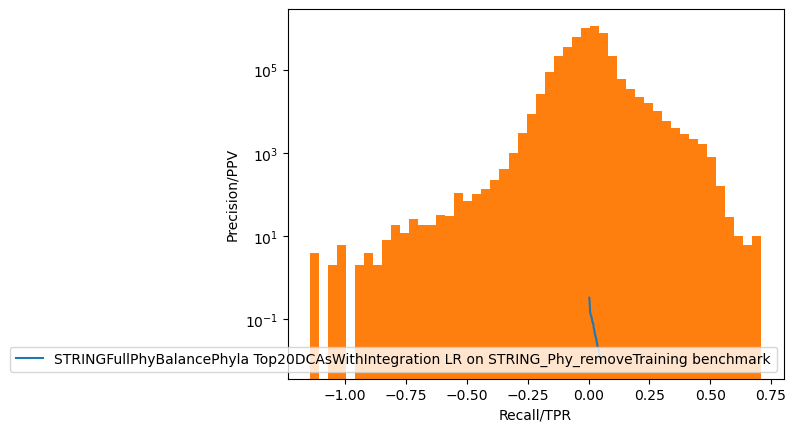

In [72]:

plt.yscale("log")
_=plt.hist(APCed_maxRFProb_pairwise_matrix.flatten(),bins=50,)

plt.show()

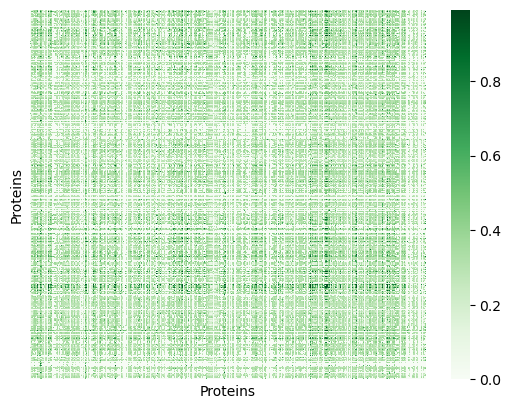

In [73]:
# %%time 
ax = sns.heatmap(np.nan_to_num(maxRFProb_pairwise_matrix),cmap="Greens",xticklabels=False,yticklabels=False)
plt.xlabel("Proteins")
plt.ylabel("Proteins")
plt.show()


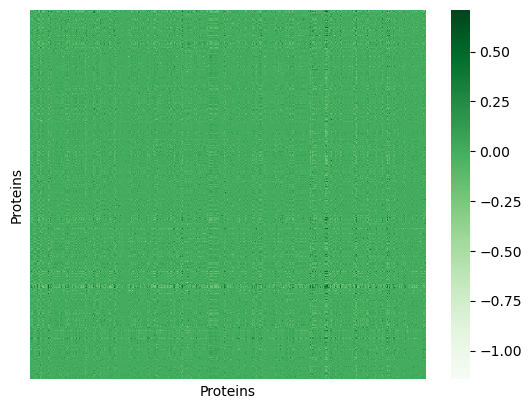

In [74]:
# %%time 
ax = sns.heatmap(np.nan_to_num(APCed_maxRFProb_pairwise_matrix),cmap="Greens",xticklabels=False,yticklabels=False)
plt.xlabel("Proteins")
plt.ylabel("Proteins")
plt.show()


# check why here is not smoothed 


In [75]:
APCed_maxRFProb_pairwise_matrix[0:3,0:20]

array([[        nan,  0.06410616,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,  0.02111772, -0.01088494,         nan, -0.04980691,
                nan,         nan,         nan,  0.01052555,         nan],
       [ 0.06410616,         nan,  0.07133919,  0.03023052, -0.13787707,
        -0.05989229,         nan,  0.09745475, -0.14530647,  0.02263044,
         0.07613072,  0.01266214, -0.11649769, -0.00279541, -0.07285308,
        -0.08596402,  0.14284711,  0.04401791, -0.12837425, -0.15476691],
       [        nan,  0.07133919,         nan,  0.03720028, -0.13588369,
        -0.01167571,         nan,  0.01507459, -0.14209888,  0.00328489,
         0.08570879,  0.08399674, -0.13258726,  0.08365561,  0.01485842,
        -0.10368498,  0.09036149,  0.04166898, -0.12783602, -0.15468458]])

In [76]:
maxRFProb_pairwise_matrix[0:3,0:20]


array([[       nan, 0.383971  ,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan, 0.52052996, 0.293611  ,        nan, 0.34326115,
               nan,        nan,        nan, 0.33536749,        nan],
       [0.383971  ,        nan, 0.33089641, 0.29476172, 0.10960948,
        0.23085897,        nan, 0.3702155 , 0.07727105, 0.28163579,
        0.31539422, 0.35856617, 0.09440297, 0.20178951, 0.1993946 ,
        0.21341262, 0.432423  , 0.3222788 , 0.0966185 , 0.07653075],
       [       nan, 0.33089641,        nan, 0.34711846, 0.15406542,
        0.32896126,        nan, 0.33463432, 0.11866741, 0.30672913,
        0.36602397, 0.48924933, 0.11449873, 0.32334223, 0.33381706,
        0.24705727, 0.42962142, 0.36767255, 0.13575992, 0.11629803]])

In [77]:
%%time 
   
Query_maxRFProbs_dict=dict()
for i in range(maxRFProb_pairwise_matrix.shape[0]):
    for j in range(maxRFProb_pairwise_matrix.shape[1]):
        if not np.isnan(maxRFProb_pairwise_matrix[i,j]):
            Query_maxRFProbs_dict[tuple(sorted((Unique_Ecoli_idx2pro_dict[i],Unique_Ecoli_idx2pro_dict[j])))]=maxRFProb_pairwise_matrix[i,j]
print(len(Query_maxRFProbs_dict))     

2269192
CPU times: user 17.1 s, sys: 78.8 ms, total: 17.2 s
Wall time: 17.2 s


In [78]:
%%time 
   
Query_maxAPCedRFProbs_dict=dict()
for i in range(APCed_maxRFProb_pairwise_matrix.shape[0]):
    for j in range(APCed_maxRFProb_pairwise_matrix.shape[1]):
        if not np.isnan(APCed_maxRFProb_pairwise_matrix[i,j]):
            Query_maxAPCedRFProbs_dict[tuple(sorted((Unique_Ecoli_idx2pro_dict[i],Unique_Ecoli_idx2pro_dict[j])))]=APCed_maxRFProb_pairwise_matrix[i,j]
print(len(Query_maxAPCedRFProbs_dict))     

2269192
CPU times: user 17.3 s, sys: 103 ms, total: 17.4 s
Wall time: 17.4 s


In [79]:
%%time

Query_maxRFProbs=[Query_maxRFProbs_dict[pp] for pp in Query_PPs]

Query_maxAPCedRFProbs=[Query_maxAPCedRFProbs_dict[pp] for pp in Query_PPs]
Query_maxAPCedRFProb_PPs=[pp for pp in Query_PPs]


len(Query_maxRFProbs)

CPU times: user 3.41 s, sys: 132 ms, total: 3.54 s
Wall time: 3.54 s


2269192

# figure 5:  appllication to all-to-all results 

maxDCA:postiveControlCount:10861;allPredCount:376147;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0844 917.0
Top20DCAsWithIntegration RF:postiveControlCount:10861;allPredCount:376147;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0844 917.0
maxDCA:postiveControlCount:1018;allPredCount:425473;
Final F1, precision, recall,TP:  0.0029 0.0014 0.5982 609.0
Top20DCAsWithIntegration RF:postiveControlCount:1018;allPredCount:425473;
Final F1, precision, recall,TP:  0.0029 0.0014 0.5982 609.0


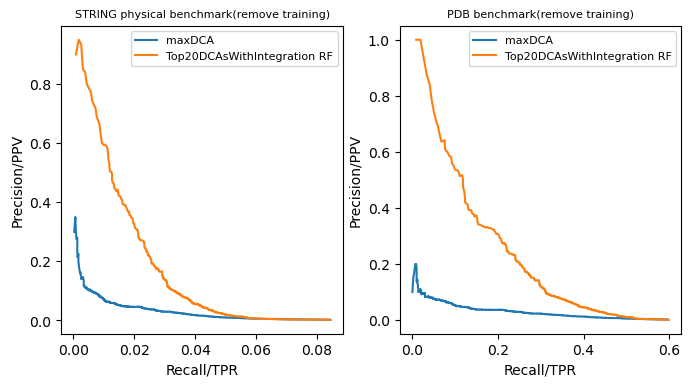

CPU times: user 19 s, sys: 601 ms, total: 19.6 s
Wall time: 19.8 s


In [80]:
%%time 
# Fig 35
# https://towardsdatascience.com/4-simple-tips-for-plotting-multiple-graphs-in-python-38df2112965c
# https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html

fig5 = plt.figure(figsize=(8,4))

step=10 #1000 #10, 1
zoom_thres=None


colors=['#ffff33', '#ff7f00', '#984ea3', '#4daf4a', '#377eb8', '#e41a1c']

axA = plt.subplot(1,2,1)
#zoom_thres=60000#None#100000  #2269192,30000, 300
print_results=True

return_bestF1=None 



Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="maxDCA",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                               
                                              )
Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                                                         Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="Top20DCAsWithIntegration RF",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )





#plt.legend(loc='best')
#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
#axA.set_title("Performance ",loc='left',loc='center',fontsize=10)
#ax1.set_xlabel("taaata",loc='left top')
# axA.text(-1000, 1000, 'A', weight='bold')
axA.set_title("STRING physical benchmark(remove training)",loc='center',fontsize=8)
axA.legend(fontsize=8)



axB =plt.subplot(1,2,2)
#zoom_thres=30000#None#100000  #2269192,30000, 300
print_results=True


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="maxDCA",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,
                                                                         Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="Top20DCAsWithIntegration RF",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )





#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# axB.text(-300, 1000, 'B', weight='bold')
axB.set_title("PDB benchmark(remove training)",loc='center',fontsize=8)
axB.legend(fontsize=8)




plt.show()

fig5.savefig("/mnt/mnemo5/tao/temp_figures/Fig5.pdf", dpi=600)


# here recall is low, because not all pp in pdb or string physical benchmark can pass filtering steps ?!!!!
# more eays to understand from figure without removing training data, the recall is still lower then 1 at the end !!

# when use step=1， 36min 57

fixedRatio Top20DCAsWithIntegration RF:postiveControlCount:10861;allPredCount:376147;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0844 917.0
maxDCA:postiveControlCount:10861;allPredCount:376147;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0844 917.0
maxDCA of All phylum:postiveControlCount:10861;allPredCount:376147;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0844 917.0
fixedRatio Top20DCAsWithIntegration RF:postiveControlCount:1018;allPredCount:425473;
Final F1, precision, recall,TP:  0.0029 0.0014 0.5982 609.0
maxDCA:postiveControlCount:1018;allPredCount:425473;
Final F1, precision, recall,TP:  0.0029 0.0014 0.5982 609.0
maxDCA of All phylum:postiveControlCount:1018;allPredCount:425473;
Final F1, precision, recall,TP:  0.0029 0.0014 0.5982 609.0


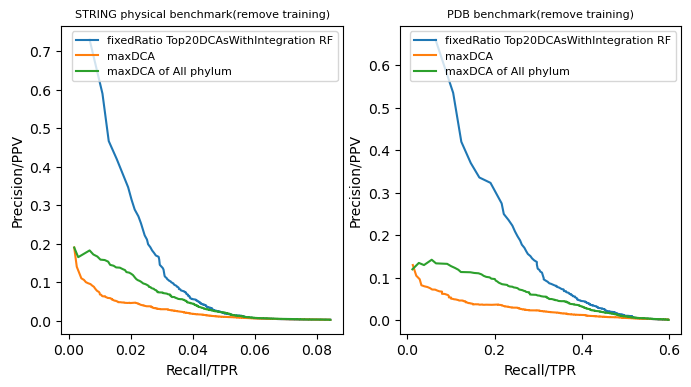

CPU times: user 7.52 s, sys: 446 ms, total: 7.97 s
Wall time: 7.57 s


In [81]:
%%time 
# Fig 35
# https://towardsdatascience.com/4-simple-tips-for-plotting-multiple-graphs-in-python-38df2112965c
# https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html

fig5 = plt.figure(figsize=(8,4))

step=100 #1000 #10, 1
zoom_thres=None


colors=['#ffff33', '#ff7f00', '#984ea3', '#4daf4a', '#377eb8', '#e41a1c']

axA = plt.subplot(1,2,1)
#zoom_thres=60000#None#100000  #2269192,30000, 300
print_results=True

return_bestF1=None 
Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                                                         Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="fixedRatio Top20DCAsWithIntegration RF",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )



Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="maxDCA",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                               
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="maxDCA of All phylum",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                              )



#plt.legend(loc='best')
#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
#axA.set_title("Performance ",loc='left',loc='center',fontsize=10)
#ax1.set_xlabel("taaata",loc='left top')
# axA.text(-1000, 1000, 'A', weight='bold')
axA.set_title("STRING physical benchmark(remove training)",loc='center',fontsize=8)
axA.legend(fontsize=8)



axB =plt.subplot(1,2,2)
#zoom_thres=30000#None#100000  #2269192,30000, 300
print_results=True


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,
                                                                         Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="fixedRatio Top20DCAsWithIntegration RF",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="maxDCA",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="maxDCA of All phylum",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                              )



#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# axB.text(-300, 1000, 'B', weight='bold')
axB.set_title("PDB benchmark(remove training)",loc='center',fontsize=8)
axB.legend(fontsize=8)




plt.show()

fig5.savefig("/mnt/mnemo5/tao/temp_figures/Fig5.pdf", dpi=600)


# here recall is low, because not all pp in pdb or string physical benchmark can pass filtering steps ?!!!!
# more eays to understand from figure without removing training data, the recall is still lower then 1 at the end !!

# when use step=1， 36min 57

## get some statistics 

In [82]:
def get_all2All_statistics(PPs,RF_results,benchmark_dict,
                           trainPP_dict,
                           return_FixNum=None,
                           rf_prob_thres=0.65,
                          ):
    def F1_score(PPV,TPR):
        return(2*(PPV*TPR)/(PPV+TPR))

    print(len(RF_results))

    if return_FixNum is None:
        RF_posIdx=[idx for idx, prob in enumerate(RF_results) if prob >rf_prob_thres]
        RF_pos_results=[RF_results[idx] for idx in RF_posIdx]
        RF_pos_PPs=[PPs[idx] for idx in RF_posIdx]
    else:
        RF_results=np.array(RF_results)
        PPs=np.array(PPs)

        Ascending_orderIdx=np.argsort(RF_results)
        Descending_orderIdx=Ascending_orderIdx[::-1]

        RF_results=RF_results[Descending_orderIdx]
        PPs=PPs[Descending_orderIdx]
        
        RF_pos_results=RF_results[0:return_FixNum]
        RF_pos_PPs=PPs[0:return_FixNum]
        RF_pos_PPs=[tuple(pp) for pp in RF_pos_PPs]


    result_posLen=len(RF_pos_PPs)
    result_TP=sum([1 for pp in RF_pos_PPs if pp in benchmark_dict ])


    benchmark_P=len(benchmark_dict)
    
    TP_notInTraining=sum([1 for pp in RF_pos_PPs if (pp in benchmark_dict) and (pp not in trainPP_dict) ])
    pos_notInTraining=sum([1 for pp in RF_pos_PPs if pp not in trainPP_dict ])

    print("result_TP,result_posLen,benchmark_P:",result_TP,result_posLen,benchmark_P)
    
    print("TP not in training", TP_notInTraining)
    print("pos_notInTraining",pos_notInTraining)
    
    precision=np.round(result_TP/result_posLen,decimals=2)
    recall=np.round(result_TP/benchmark_P,decimals=2)
    f1=np.round(F1_score(precision,recall),decimals=2)
    print("Precision, Recall,F1:",precision,recall,f1)
    return(result_TP,TP_notInTraining,precision,recall,f1)

In [83]:
all2all_benchmarkLabel=["STRING physical (15476)","PDB (3657)"]
all2all_talle_dict=dict()
all2all_talle_dict["STRING physical (15476)"]=pd.DataFrame(np.zeros((3,5)),
                                              index=["maxDCA","maxDCA of All phylum","fixedRatio Top20DCAsWithIntegration RF"],
                                              columns=["TP","TP not in training","Pre","Rec","F-score",])
all2all_talle_dict["PDB (3657)"]=pd.DataFrame(np.zeros((3,5)),
                                              index=["maxDCA","maxDCA of All phylum","fixedRatio Top20DCAsWithIntegration RF"],
                                              columns=["TP","TP not in training","Pre","Rec","F-score",])

In [84]:
len(STRINGcurrentSpePhyPPI_posPPI_dict),len(pdb_PPs_dict)

(15476, 3657)

In [85]:
rf_prob_thres=0.7
return_FixNum=20000#20000
all2all_talle_dict["STRING physical (15476)"].loc["fixedRatio Top20DCAsWithIntegration RF",:]=get_all2All_statistics(PPs=Query_BestHomologousDCAs_top5DCAs_PPs,
                       RF_results=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                       benchmark_dict=STRINGcurrentSpePhyPPI_posPPI_dict,
                       trainPP_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)
all2all_talle_dict["PDB (3657)"].loc["fixedRatio Top20DCAsWithIntegration RF",:]=get_all2All_statistics(PPs=Query_BestHomologousDCAs_top5DCAs_PPs,
                       RF_results=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                       benchmark_dict=pdb_PPs_dict,
                       trainPP_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)

2269192
result_TP,result_posLen,benchmark_P: 2090 20000 15476
TP not in training 346
pos_notInTraining 17444
Precision, Recall,F1: 0.1 0.14 0.12
2269192
result_TP,result_posLen,benchmark_P: 1944 20000 3657
TP not in training 329
pos_notInTraining 17444
Precision, Recall,F1: 0.1 0.53 0.17


In [86]:
# rf_prob_thres=0.7
# return_FixNum=20000#20000
# all2all_talle_dict["STRING physical (15476)"].loc["unFixedRatio Top20DCAsWithIntegration RF",:]=get_all2All_statistics(PPs=Query_BestHomologousDCAs_top5DCAs_PPs,
#                        RF_results=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
#                        benchmark_dict=STRINGcurrentSpePhyPPI_posPPI_dict,
#                        trainPP_dict=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,
#                        return_FixNum=return_FixNum,
#                        rf_prob_thres=rf_prob_thres)
# all2all_talle_dict["PDB (3657)"].loc["unFixedRatio Top20DCAsWithIntegration RF",:]=get_all2All_statistics(PPs=Query_BestHomologousDCAs_top5DCAs_PPs,
#                        RF_results=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
#                        benchmark_dict=pdb_PPs_dict,
#                        trainPP_dict=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,
#                        return_FixNum=return_FixNum,
#                        rf_prob_thres=rf_prob_thres)

In [87]:
rf_prob_thres=2
return_FixNum=20000#20000
all2all_talle_dict["STRING physical (15476)"].loc["maxDCA of All phylum",:]=get_all2All_statistics(PPs=Query_BestHomologousDCAs_top5DCAs_PPs,
                       RF_results=Query_BestHomologousDCAs_top5DCAs_maxDCAs,
                       benchmark_dict=STRINGcurrentSpePhyPPI_posPPI_dict,
                       trainPP_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)
all2all_talle_dict["PDB (3657)"].loc["maxDCA of All phylum",:]=get_all2All_statistics(PPs=Query_BestHomologousDCAs_top5DCAs_PPs,
                       RF_results=Query_BestHomologousDCAs_top5DCAs_maxDCAs,
                       benchmark_dict=pdb_PPs_dict,
                       trainPP_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)

2269192
result_TP,result_posLen,benchmark_P: 1486 20000 15476
TP not in training 280
pos_notInTraining 17258
Precision, Recall,F1: 0.07 0.1 0.08
2269192
result_TP,result_posLen,benchmark_P: 1361 20000 3657
TP not in training 258
pos_notInTraining 17258
Precision, Recall,F1: 0.07 0.37 0.12


In [88]:
rf_prob_thres=1.8
return_FixNum=20000#20000
all2all_talle_dict["STRING physical (15476)"].loc["maxDCA",:]=get_all2All_statistics(PPs=Query_PPs,
                       RF_results=Query_maxDCAs,
                       benchmark_dict=STRINGcurrentSpePhyPPI_posPPI_dict,
                       trainPP_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)
all2all_talle_dict["PDB (3657)"].loc["maxDCA",:]=get_all2All_statistics(PPs=Query_PPs,
                       RF_results=Query_maxDCAs,
                       benchmark_dict=pdb_PPs_dict,
                       trainPP_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)

2269192
result_TP,result_posLen,benchmark_P: 934 20000 15476
TP not in training 165
pos_notInTraining 18430
Precision, Recall,F1: 0.05 0.06 0.05
2269192
result_TP,result_posLen,benchmark_P: 822 20000 3657
TP not in training 147
pos_notInTraining 18430
Precision, Recall,F1: 0.04 0.22 0.07


In [89]:
all2all_talle_dict["STRING physical (15476)"]

,TP,TP not in training,Pre,Rec,F-score
maxDCA,934.0,165.0,0.05,0.06,0.05
maxDCA of All phylum,1486.0,280.0,0.07,0.10,0.08
fixedRatio Top20DCAsWithIntegration RF,2090.0,346.0,0.10,0.14,0.12


In [90]:
all2all_talle_dict["PDB (3657)"]

,TP,TP not in training,Pre,Rec,F-score
maxDCA,822.0,147.0,0.04,0.22,0.07
maxDCA of All phylum,1361.0,258.0,0.07,0.37,0.12
fixedRatio Top20DCAsWithIntegration RF,1944.0,329.0,0.10,0.53,0.17


### save table, figure 4C

then copy these result to table  /Users/taof/Documents/PhD_Tao/conference/presentations/all2all.numbers



# alphafold further filtering  for direct and functional  PPI benchmark after full  STRINGPhyBalancePhyla  phylum integration

fron now not important  to show phylum integration ml model 

In [91]:

EggNog1224_output_path=f"/mnt/mnemo6/tao/colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve1224/"

EggNog1224_figure_prefiex=""

model_key='model_3'

## prepare benchmark 

In [92]:
# prepare kegg benchmark 
#http://localhost:8206/lab/workspaces/auto-r/tree/code/MNF/notebooks/STRING_Data_11.5/script_CoEvo_EggNOG_preprocessing_STRING1105_varyEggNOGMaxLevels_prepareKEGGBenchmark.ipynb

currentSpe_TaxID=Query_tuple[1]


KEGGPPI_benchmark_file="/mnt/mnemo6/damian/STRING_derived_v11.5/kegg_2020/kegg_benchmarking.CONN_maps_in.v11.5.tsv"
KEGGPPI_benchmark=pd.read_csv(KEGGPPI_benchmark_file,
                          header=None,index_col=None, sep="\t")

print(KEGGPPI_benchmark.shape)
# KEGGPPI_benchmark.head(n=3)
#set(kegg_benchmark.iloc[:,1])


KEGGPPI_benchmark_speID=KEGGPPI_benchmark.iloc[:,0].tolist()
KEGGPPI_benchmark_currentSpe_Idx=[i for i,s in enumerate(KEGGPPI_benchmark_speID) if s ==int(currentSpe_TaxID)]
currentSpe_KEGGPPI_benchmark=KEGGPPI_benchmark.loc[KEGGPPI_benchmark_currentSpe_Idx,:]
print(currentSpe_KEGGPPI_benchmark.shape)

currentSpe_KEGGPPI_pathways=currentSpe_KEGGPPI_benchmark.iloc[:,3].tolist()
currentSpe_KEGGPPI_pathways=[l.split() for l in currentSpe_KEGGPPI_pathways]

# here notice is  l only with one protein, get empty
currentSpe_KEGGPPI_posPPI=[list(itertools.combinations(l,2)) for l in currentSpe_KEGGPPI_pathways]

currentSpe_KEGGPPI_posPPI=[pp for l in currentSpe_KEGGPPI_posPPI for pp in l] # genereate reversed pp and extend list of list
print("len(currentSpe_KEGGPPI_posPPI):",len(currentSpe_KEGGPPI_posPPI))
print(currentSpe_KEGGPPI_posPPI[0:3])





currentSpe_KEGGPPI_posPPI=[tuple(sorted(pp)) for pp in currentSpe_KEGGPPI_posPPI]
currentSpe_KEGGPPI_posPPI=list(set(currentSpe_KEGGPPI_posPPI))
print("sort protein pair and set,len(currentSpe_KEGGPPI_posPPI):",len(currentSpe_KEGGPPI_posPPI))


currentSpe_KEGGPPI_posPPI=[(currentSpe_TaxID+"."+p1,currentSpe_TaxID+"."+p2) for p1, p2 in currentSpe_KEGGPPI_posPPI]
print("len(currentSpe_KEGGPPI_posPPI)",len(currentSpe_KEGGPPI_posPPI))




currentSpe_KEGGPPI_posPPI_dict=dict([(pp,1) for pp in currentSpe_KEGGPPI_posPPI])
print("len(currentSpe_KEGGPPI_posPPI_dict)",len(currentSpe_KEGGPPI_posPPI_dict))
print(list(currentSpe_KEGGPPI_posPPI_dict.items())[0:3])



(371602, 4)
(204, 4)
len(currentSpe_KEGGPPI_posPPI): 34786
[('b0114', 'b0115'), ('b0114', 'b1378'), ('b0114', 'b3403')]
sort protein pair and set,len(currentSpe_KEGGPPI_posPPI): 28914
len(currentSpe_KEGGPPI_posPPI) 28914
len(currentSpe_KEGGPPI_posPPI_dict) 28914
[(('511145.b0968', '511145.b1967'), 1), (('511145.b2210', '511145.b3212'), 1), (('511145.b1302', '511145.b2844'), 1)]


In [93]:
# 
# from file http://localhost:8206/lab/workspaces/auto-l/tree/code/STRING_TAO/PPI_Coevolution/QianPDB_UniprotID2StringID.ipynb
# sheet_name=8
Qian_benchmarkLabel_list=["QianY2H","QianAPMS","QianECOCYC","QianPDB"]
Qian_benchmark_PPI_dict=dict()
for benchmarkLabel in Qian_benchmarkLabel_list:
    print(benchmarkLabel)
    Qian_Ecoli_PPI=pd.read_csv(filepath_or_buffer=f'/mnt/mnemo5/tao/PPI_Coevolution/QianCong_Paper/{benchmarkLabel}_PPI.csv',
                          header=0,index_col=None)
                          #sep=" ",header=True,index=None)
    print(Qian_Ecoli_PPI.shape)


    Qian_Ecoli_PPI_pps=Qian_Ecoli_PPI["Pair (String IDs)"].values.tolist()

    Qian_Ecoli_PPI_pps=[pp.split("_") for pp in Qian_Ecoli_PPI_pps]

    print(len(Qian_Ecoli_PPI_pps))
    Qian_Ecoli_PPI_pps=[sorted((p1,p2)) for p1,p2 in Qian_Ecoli_PPI_pps if (p1!='NoRecord') and (p2!='NoRecord')]
    print(len(Qian_Ecoli_PPI_pps))
    Qian_Ecoli_PPI_pps=[tuple(pp) for pp in Qian_Ecoli_PPI_pps ]
    Qian_Ecoli_PPI_pps_dict={pp:1 for pp in Qian_Ecoli_PPI_pps}
    
    Qian_benchmark_PPI_dict[benchmarkLabel]=Qian_Ecoli_PPI_pps_dict
    
    print("len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps):",len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps))
    
print("pdb_complex")
Qian_benchmark_PPI_dict["pdb_complex"]=pdb_complex_PPs_dict
print("len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps):",len(pdb_complex_PPs_dict),len(pdb_complex_PPs))



print("KEGG")
Qian_benchmark_PPI_dict["KEGG"]=currentSpe_KEGGPPI_posPPI_dict
print("len(Qian_Ecoli_PPI_pps_dict):",len(currentSpe_KEGGPPI_posPPI_dict))





QianY2H
(277, 7)
277
275
len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps): 275 275
QianAPMS
(1245, 7)
1245
1236
len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps): 1236 1236
QianECOCYC
(916, 7)
916
892
len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps): 892 892
QianPDB
(868, 7)
868
765
len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps): 765 765
pdb_complex
len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps): 3243 3243
KEGG
len(Qian_Ecoli_PPI_pps_dict): 28914


In [94]:
%%time

print(len(pdb_interact_PPs),sum([1 for pp in Query_PPs if pp in pdb_interact_PPs_dict]))
print(len(pdb_complex_PPs),sum([1 for pp in Query_PPs if pp in pdb_complex_PPs_dict]))

for benchmarkLabel, Qian_Ecoli_PPI_pps_dict in Qian_benchmark_PPI_dict.items():
    print(benchmarkLabel)
    print(len(Qian_Ecoli_PPI_pps_dict),sum([1 for pp in Query_PPs if pp in  Qian_Ecoli_PPI_pps_dict]))


414 294
3243 2954
QianY2H
275 156
QianAPMS
1236 797
QianECOCYC
892 515
QianPDB
765 382
pdb_complex
3243 2954
KEGG
28914 16201
CPU times: user 1.03 s, sys: 8.12 ms, total: 1.04 s
Wall time: 1.04 s


In [95]:
%%time


for benchmarkLabel, Qian_Ecoli_PPI_pps_dict in Qian_benchmark_PPI_dict.items():
    print(benchmarkLabel)
    print(len(Qian_Ecoli_PPI_pps_dict),sum([1 for pp in Qian_Ecoli_PPI_pps_dict.keys() if pp in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs]))


QianY2H
275 104
QianAPMS
1236 408
QianECOCYC
892 397
QianPDB
765 228
pdb_complex
3243 2393
KEGG
28914 2056
CPU times: user 7.39 ms, sys: 342 µs, total: 7.73 ms
Wall time: 7.37 ms


## sel final PP list from differente methods 

In [96]:
def FixNum_of_topResults(prob_results,PPs,prob_thres,return_FixNum=None):
    if return_FixNum is None:
        posIdx=[idx for idx, prob in enumerate(prob_results) if prob >prob_thres]
        print("len(posIdx):",len(posIdx))
        pos_results=[prob_results[idx] for idx in posIdx]
        pos_PPs=[PPs[idx] for idx in posIdx]
    else:
        prob_results=np.array(prob_results)
        PPs=np.array(PPs)

        Ascending_orderIdx=np.argsort(prob_results)
        Descending_orderIdx=Ascending_orderIdx[::-1]

        prob_results=prob_results[Descending_orderIdx]
        PPs=PPs[Descending_orderIdx]

        pos_results=prob_results[0:return_FixNum]
        pos_PPs=PPs[0:return_FixNum]
        pos_PPs=[tuple(pp) for pp in pos_PPs]
    return(pos_PPs)

In [ ]:
%%time
# RF_thres=0.65 #0.5 ,0.65, 0.7  # 0.7,0.8
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_selIdx=[idx for idx,RF in enumerate(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results) if (RF>=RF_thres)] #  and (Query_maxAPCedDCAs[idx]>maxAPCedDCA_thres)
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList=[Query_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_selIdx]


RF_thres=0.65
# return_FixNum=15000
return_FixNum=None
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                                     Query_BestHomologousDCAs_top5DCAs_PPs,
                                                     prob_thres=RF_thres,return_FixNum=return_FixNum)

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList))



STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_argument_toget_interprotein_prob12=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(pp+Query_allPPI_allInfo_dict[pp]) for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList]

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_argument_toget_interprotein_prob12))

pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_argument_toget_interprotein_prob12)
pool.close() 

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_list))
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict={(p1,p2):max_interprotein_prob12 for p1, p2, max_interprotein_prob12 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_list if max_interprotein_prob12 is not None}

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict))



# # use this for benchmarking when we use corrrect PP list to collect alphafold results ,from STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs=[k for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.items()]
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_results=[v for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.items()]
# sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs if pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs])

In [ ]:
%%time

maxprob12_thres=0.9
ptm_thres=0 # 0.6,0.7
# use this for benchmarking when we use corrrect PP list to collect alphafold results ,from STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs=[k for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_results=[v for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_results)


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_argument_toget_ptm=[[colab_outputPath,p1,p2] for p1,p2 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs]
pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_ptm_list=pool.map(get_ptm_from_scoreFile,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_argument_toget_ptm)
pool.close() 
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_ptm_list))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs=[(p1,p2) for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_ptm_list if ptm >=ptm_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict[(p1,p2)] for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_ptm_list if ptm >=ptm_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_results)




In [ ]:
# rf_prob_thres=0.9#0.4 0.8

# print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results))
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_posIdx=[idx for idx, prob in enumerate(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results) if prob >rf_prob_thres]
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[idx] for idx in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_posIdx]
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=[Query_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_posIdx]
# print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results))


# maxAPCedDCA_thres=0.9
rf_prob_thres=0.9#0.4 0.8
return_FixNum=None#None #15000
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                                     Query_BestHomologousDCAs_top5DCAs_PPs,
                                                     prob_thres=rf_prob_thres,return_FixNum=return_FixNum)

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs))

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_dict[pp] for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs]
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results))

In [ ]:
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList)

In [ ]:
%%time

maxAPCedRFProb_thres=0.24#0.3
return_FixNum=20000#20000#20000
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList=FixNum_of_topResults(Query_maxAPCedRFProbs,
                                                     Query_maxAPCedRFProb_PPs,
                                                     prob_thres=maxAPCedRFProb_thres,return_FixNum=return_FixNum)

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList))

In [ ]:
%%time

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_interprotein_prob12=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(pp+Query_allPPI_allInfo_dict[pp]) for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList]

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_interprotein_prob12))

pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_interprotein_prob12)
pool.close() 

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_list))
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict={(p1,p2):max_interprotein_prob12 for p1, p2, max_interprotein_prob12 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_list if max_interprotein_prob12 is not None}

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict))




In [ ]:
%%time
maxprob12_thres=0.9#0.8#0.9
ptm_thres=0 # 0.6,0.7
# use this for benchmarking when we use corrrect PP list to collect alphafold results ,from STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_PPs=[k for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_results=[v for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_results)


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_ptm=[[colab_outputPath,p1,p2] for p1,p2 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_PPs]
pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list=pool.map(get_ptm_from_scoreFile,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_ptm)
pool.close() 
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_PPs=[(p1,p2) for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list if ptm >=ptm_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict[(p1,p2)] for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list if ptm >=ptm_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_results)






In [ ]:
%%time

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_interprotein_mincm=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_unrelaxed_rank_1_"+model_key+".pdb",".custom_unrelaxed_rank_1_"+model_key+"_contactmap.npz"]+list(pp+Query_allPPI_allInfo_dict[pp]) for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList]

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_interprotein_mincm))

pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_mincm_list=pool.map(get_interprotein_mincm_from_pdb,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_interprotein_mincm)
pool.close() 
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_mincm_list))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_list=[[p1,p2,1/mincm] for p1, p2, mincm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_mincm_list if mincm is not None]
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_list))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_dict={(p1,p2):max_interprotein_inverseMinDis for p1, p2, max_interprotein_inverseMinDis in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_list}

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_dict))




In [ ]:
%%time
maxInverseMinDis_thres=0.2#0.8#0.9
ptm_thres=0 # 0.6,0.7
# use this for benchmarking when we use corrrect PP list to collect alphafold results ,from STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_PPs=[k for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_dict.items() if v >=maxInverseMinDis_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_results=[v for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_dict.items() if v >=maxInverseMinDis_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_results)



STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_ptm=[[colab_outputPath,p1,p2] for p1,p2 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_PPs]
pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list=pool.map(get_ptm_from_scoreFile,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_ptm)
pool.close() 
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_PPs=[(p1,p2) for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list if ptm >=ptm_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_dict[(p1,p2)] for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list if ptm >=ptm_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_results)







### save to compute alphafold and for visulisation purpose 




In [ ]:
with open(os.path.join(Query_Benchmark_folder,
                       f"Query_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict.pickle"),"wb") as f:
    pickle.dump(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict,f)
    
    
    
with open(os.path.join(Query_Benchmark_folder,
                       f"Query_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.pickle"),"wb") as f:
    pickle.dump(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,f)
    
    


with open(os.path.join(Query_Benchmark_folder,
                       f"Query_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_prob.pickle"),"wb") as f:
    pickle.dump(Query_maxAPCedRFProbs_dict,f)

### compare  with experimental methods, pdb_complex and KEGG  with a table 

In [ ]:
#from Qian's paper, we can get final coevolution+ based_results, but not coevoution+docking results 
Qian_Predicted_PPI=pd.read_csv(filepath_or_buffer=f'/mnt/mnemo5/tao/PPI_Coevolution/QianCong_Paper/Qian_Prediction_ecoliID.csv',
                      header=0,index_col=None,sep="\t")
                      #sep=" ",header=True,index=None)
print(Qian_Predicted_PPI.shape)

Qian_Predicted_PPI_pps=Qian_Predicted_PPI.loc[:,["str_id1","str_id2"]].values.tolist()
Qian_Predicted_pps=[tuple(sorted((p1,p2))) for p1,p2 in Qian_Predicted_PPI_pps]
print(len(Qian_Predicted_pps))

Qian_Predicted_pps_results=[1 for pp in Qian_Predicted_pps]

In [ ]:
#from http://localhost:8206/lab/workspaces/auto-r/tree/code/STRING_TAO/PPI_Coevolution/Y2H_APMS_UniprotID2StringID.ipynb
Y2H_Predicted_PPI=pd.read_csv(filepath_or_buffer=f'/mnt/mnemo5/tao/PPI_Coevolution/Y2H_Paper/PPI.csv',
                      header=0,index_col=None,sep="\t")
                      #sep=" ",header=True,index=None)
print(Y2H_Predicted_PPI.shape)

Y2H_Predicted_PPI_pps=Y2H_Predicted_PPI["Pair (String IDs)"].values.tolist()
Y2H_Predicted_PPI_pps=[pp.split("_") for pp in Y2H_Predicted_PPI_pps]
print(len(Y2H_Predicted_PPI_pps))
Y2H_Predicted_pps=[tuple(sorted((p1,p2))) for p1,p2 in Y2H_Predicted_PPI_pps if (p1!='NoRecord') and (p2!='NoRecord')]
print(len(Y2H_Predicted_pps))
print(len(set(Y2H_Predicted_pps)))

Y2H_Predicted_pps_results=[1 for pp in Y2H_Predicted_pps]

In [ ]:
#from http://localhost:8206/lab/workspaces/auto-r/tree/code/STRING_TAO/PPI_Coevolution/Y2H_APMS_UniprotID2StringID.ipynb
APMS1_Predicted_PPI=pd.read_csv(filepath_or_buffer=f'/mnt/mnemo5/tao/PPI_Coevolution/APMS1_Paper/PPI.csv',
                      header=0,index_col=None,sep="\t")
                      #sep=" ",header=True,index=None)
print(APMS1_Predicted_PPI.shape)

APMS1_Predicted_PPI_pps=APMS1_Predicted_PPI["Pair (String IDs)"].values.tolist()
APMS1_Predicted_PPI_pps=[pp.split("_") for pp in APMS1_Predicted_PPI_pps]
print(len(APMS1_Predicted_PPI_pps))
APMS1_Predicted_pps=[tuple(sorted((p1,p2))) for p1,p2 in APMS1_Predicted_PPI_pps if (p1!='NoRecord') and (p2!='NoRecord')]
print(len(APMS1_Predicted_pps))
print(len(set(APMS1_Predicted_pps)))

APMS1_Predicted_pps_results=APMS1_Predicted_PPI["Probability Score"].values.tolist()

In [ ]:
#from http://localhost:8206/lab/workspaces/auto-r/tree/code/STRING_TAO/PPI_Coevolution/Y2H_APMS_UniprotID2StringID.ipynb
APMS2_Predicted_PPI=pd.read_csv(filepath_or_buffer=f'/mnt/mnemo5/tao/PPI_Coevolution/APMS2_Paper/PPI.csv',
                      header=0,index_col=None,sep="\t")
                      #sep=" ",header=True,index=None)
print(APMS2_Predicted_PPI.shape)

APMS2_Predicted_PPI_pps=APMS2_Predicted_PPI["Pair (String IDs)"].values.tolist()
APMS2_Predicted_PPI_pps=[pp.split("_") for pp in APMS2_Predicted_PPI_pps]
print(len(APMS2_Predicted_PPI_pps))
APMS2_Predicted_pps=[tuple(sorted((p1,p2))) for p1,p2 in APMS2_Predicted_PPI_pps if (p1!='NoRecord') and (p2!='NoRecord')]
print(len(APMS2_Predicted_pps))
print(len(set(APMS2_Predicted_pps)))

APMS2_Predicted_pps_results=APMS2_Predicted_PPI["Probability Score"].values.tolist()

In [ ]:
experiment_benchmarkLabel=["QianY2H","QianAPMS","QianECOCYC","QianPDB","pdb_complex","KEGG"]
comparison_talle_dict=dict()
comparison_talle_dict["QianY2H"]=pd.DataFrame([[59,0.028,0.213,0.049],
                                               [77,0.013,0.278,0.025],
                                               [33,0.003,0.119,0.005],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               [30,0.037,0.108,0.056],
                                              ],
                                              # index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking","AlphafoldFrommaxAPCedDCA","AlphafoldFromRF","AlphafoldFromRFplusAPC",],
                                              index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking",],
                                              columns=["TP","Pre","Rec","F-score",],
                                              # dtype=[("TP",int),("Pre",float),("Rec",float),]("F-score",float),
                                             )
comparison_talle_dict["QianAPMS"]=pd.DataFrame([[22,0.01,0.018,0.013],
                                               [26,0.004,0.021,0.007],
                                               [243,0.019,0.195,0.035],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               #  [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                                [175,0.218,0.141,0.171],
                                              ],
                                              # index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking","AlphafoldFrommaxAPCedDCA","AlphafoldFromRF","AlphafoldFromRFplusAPC",],
                                                index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking",],
                                              columns=["TP","Pre","Rec","F-score",])


comparison_talle_dict["QianECOCYC"]=pd.DataFrame([[54,0.026,0.059,0.036],
                                                  [96,0.016,0.105,0.028],
                                                  [177,0.014,0.193,0.026],
                                                  # [np.nan,np.nan,np.nan,np.nan],
                                                  # [np.nan,np.nan,np.nan,np.nan],
                                                  # [np.nan,np.nan,np.nan,np.nan],
                                                  [198,0.246,0.216,0.230],
                                              ],
                                              # index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking","AlphafoldFrommaxAPCedDCA","AlphafoldFromRF","AlphafoldFromRFplusAPC"],
                                                 index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking",],
                                              columns=["TP","Pre","Rec","F-score",])


comparison_talle_dict["QianPDB"]=pd.DataFrame([[45,0.021,0.052,0.03],
                                               [80,0.013,0.092,0.023],
                                               [64,0.005,0.074,0.009],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               [104,0.129,0.12,0.124],
                                              ],
                                              # index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking","AlphafoldFrommaxAPCedDCA","AlphafoldFromRF","AlphafoldFromRFplusAPC"],
                                              index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking",],
                                              columns=["TP","Pre","Rec","F-score",])

comparison_talle_dict["pdb_complex"]=pd.DataFrame([[np.nan,np.nan,np.nan,np.nan],
                                               [np.nan,np.nan,np.nan,np.nan],
                                               [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               [np.nan,np.nan,np.nan,np.nan],
                                              ],
                                              # index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking","AlphafoldFrommaxAPCedDCA","AlphafoldFromRF","AlphafoldFromRFplusAPC",],
                                                  index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking",],
                                              columns=["TP","Pre","Rec","F-score",])


comparison_talle_dict["KEGG"]=pd.DataFrame([[np.nan,np.nan,np.nan,np.nan],
                                               [np.nan,np.nan,np.nan,np.nan],
                                               [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               [np.nan,np.nan,np.nan,np.nan],
                                              ],
                                              # index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking","AlphafoldFrommaxAPCedDCA","AlphafoldFromRF","AlphafoldFromRFplusAPC",],
                                                  index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking",],
                                              columns=["TP","Pre","Rec","F-score",])


In [ ]:
%%time
step=1
zoom_thres=None
filter_thres=None#0.9 # 0.9 is best seem ?, 0.85 similar but worse, 0.8 is also okay
print_results=True

# one thing to notice here is that BestF1 doesnt neceeary show best TP count  !!!
# in the end , we decide a alphafold prob12 to select final TP ,

return_bestF1=True

for benchmarkLabel in experiment_benchmarkLabel:
# for benchmarkLabel in ["QianAPMS"]:
    print("********************************************")
    plt.figure()
    
    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Y2H_Predicted_pps_results,
                                                   Y2H_Predicted_pps,
                                                   IndepedentBenchmark_pps_dict=Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"Y2H  on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                   filter_thres=filter_thres,
                                                   print_results=print_results,    
                                                    return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["Y2H",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(APMS1_Predicted_pps_results,
                                                   APMS1_Predicted_pps,
                                                   IndepedentBenchmark_pps_dict=Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"APMS1  on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                   filter_thres=filter_thres,
                                                   print_results=print_results,    
                                                    return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["APMS 1",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    
    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(APMS2_Predicted_pps_results,
                                                   APMS2_Predicted_pps,
                                                   IndepedentBenchmark_pps_dict=Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"APMS2  on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                   filter_thres=filter_thres,
                                                   print_results=print_results,    
                                                    return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["APMS 2",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Qian_Predicted_pps_results,
                                                   Qian_Predicted_pps,
                                                   IndepedentBenchmark_pps_dict=Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"Qian Coevolution+  on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                   filter_thres=filter_thres,
                                                   print_results=print_results,    
                                                    return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["Qian Coevolution+",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
          
    # FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Query_maxAPCedDCAs_interprotein_maxprob12_results,
    #                                                Query_maxAPCedDCAs_interprotein_maxprob12_PPs,
    #                                                IndepedentBenchmark_pps_dict=Qian_benchmark_PPI_dict[benchmarkLabel], 
    #                                                count_label="rate",
    #                                                legend=f"maxAPCedDCA  on {benchmarkLabel} benchmark",
    #                                                step=step,
    #                                                zoom_thres=zoom_thres,
    #                                                filter_thres=filter_thres,
    #                                                print_results=print_results,    
    #                                                 return_bestF1=return_bestF1
    #                                               )
    # #comparison_talle_dict[benchmarkLabel].loc["AlphafoldFrommaxAPCedDCA",:]=BestTP,BestPrecision,BestRecall,BestF1
    # comparison_talle_dict[benchmarkLabel].loc["AlphafoldFrommaxAPCedDCA",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    # print("####### maxAPCedDCAs not in training but in this benchmark: ",sum([1 for pp in Query_maxAPCedDCAs_interprotein_maxprob12_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )

    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results,
                                                   STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                                                   IndepedentBenchmark_pps_dict=Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"RF  on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                   filter_thres=filter_thres,
                                                   print_results=print_results,    
                                                    return_bestF1=return_bestF1
                                                  )
    #comparison_talle_dict[benchmarkLabel].loc["AlphafoldFrommaxAPCedDCA",:]=BestTP,BestPrecision,BestRecall,BestF1
    comparison_talle_dict[benchmarkLabel].loc["RF",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    print("####### maxAPCedDCAs not in training but in this benchmark: ",sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )

          

    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_results,
                                                   STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs,
                                                   IndepedentBenchmark_pps_dict=
                                                   Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"maxprob12 RF on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                filter_thres=filter_thres,
                                                   print_results=print_results,   
                                                   return_bestF1=return_bestF1
                                                  )
    #comparison_talle_dict[benchmarkLabel].loc["AlphafoldFromRF",:]=BestTP,BestPrecision,BestRecall,BestF1
    comparison_talle_dict[benchmarkLabel].loc["AlphafoldFromRF",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    print("####### RF not in training but in this benchmark: ",sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )

    
#     FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_results,
#                                                    STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_PPs,
#                                                    IndepedentBenchmark_pps_dict=
#                                                    Qian_benchmark_PPI_dict[benchmarkLabel], 
#                                                    count_label="rate",
#                                                    legend=f"maxprob12 RFplusAPC on {benchmarkLabel} benchmark",
#                                                    step=step,
#                                                    zoom_thres=zoom_thres,
#                                                 filter_thres=filter_thres,
#                                                    print_results=print_results,   
#                                                    return_bestF1=return_bestF1
#                                                   )
#     comparison_talle_dict[benchmarkLabel].loc["AlphafoldFromRFplusAPC",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
#     print("####### RFplusAPC not in training but in this benchmark: ",sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )

    

    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_results,
                                                   STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_PPs,
                                                   IndepedentBenchmark_pps_dict=
                                                   Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"maxprob12 maxAPCedRFProb on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                filter_thres=filter_thres,
                                                   print_results=print_results,   
                                                   return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["AlphafoldFromAPCedRFProb",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    print("####### maxAPCedRFProb not in training but in this benchmark: ",sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )


    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_results,
                                                   STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_PPs,
                                                   IndepedentBenchmark_pps_dict=
                                                   Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"maxInverseMinDis maxAPCedRFProb on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                filter_thres=filter_thres,
                                                   print_results=print_results,   
                                                   return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["maxInverseMinDis AlphafoldFromAPCedRFProb",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    print("####### maxInverseMinDis maxAPCedRFProb not in training but in this benchmark: ",sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )


#     FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs_pos_results,
#                                                    STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs_pos_PPs,
#                                                    IndepedentBenchmark_pps_dict=
#                                                    Qian_benchmark_PPI_dict[benchmarkLabel], 
#                                                    count_label="rate",
#                                                    legend=f"maxAPCedDCAs RFplusAPC on {benchmarkLabel} benchmark",
#                                                    step=step,
#                                                    zoom_thres=zoom_thres,
#                                                 filter_thres=filter_thres,
#                                                    print_results=print_results,   
#                                                    return_bestF1=return_bestF1
#                                                   )
#     comparison_talle_dict[benchmarkLabel].loc["maxAPCedDCAsFromRFplusAPC",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
#     print("####### RFplusAPC not in training but in this benchmark: ",sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs_pos_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )



    # plt.legend(  loc='upper right' )
    plt.title(benchmarkLabel)
    plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
    plt.show()


    # when step=10, zoom_thres=30000, take around 2 mins , each 
    # when step=10, zoom_thres=30000, in total takes around  14min 50s 
                                               

#### save table

save results to coparisoin with other /Users/taof/Documents/PhD_Tao/conference/presentations/experiments.numbers


In [ ]:
comparison_talle_dict.keys()

In [ ]:
comparison_talle_dict["QianY2H"].style.format({
    'TP': '{:,.0f}'.format,
    'Pre': '{:,.3f}'.format,
    'Rec': '{:,.3f}'.format,
    'F-score': '{:,.3f}'.format,
    # 'Pre': '{:,.2%}'.format,
    # 'Rec': '{:,.2%}'.format,
    # 'F-score': '{:,.2%}'.format,
})

In [ ]:
comparison_talle_dict["QianAPMS"].style.format({
    'TP': '{:,.0f}'.format,
    'Pre': '{:,.3f}'.format,
    'Rec': '{:,.3f}'.format,
    'F-score': '{:,.3f}'.format,
})

In [ ]:
comparison_talle_dict["QianECOCYC"].style.format({
    'TP': '{:,.0f}'.format,
    'Pre': '{:,.3f}'.format,
    'Rec': '{:,.3f}'.format,
    'F-score': '{:,.3f}'.format,
})

In [ ]:
comparison_talle_dict["QianPDB"].style.format({
    'TP': '{:,.0f}'.format,
    'Pre': '{:,.3f}'.format,
    'Rec': '{:,.3f}'.format,
    'F-score': '{:,.3f}'.format,
})

In [ ]:
comparison_talle_dict["pdb_complex"].style.format({
    'TP': '{:,.0f}'.format,
    'Pre': '{:,.3f}'.format,
    'Rec': '{:,.3f}'.format,
    'F-score': '{:,.3f}'.format,
})

In [ ]:
comparison_talle_dict["KEGG"].style.format({
    'TP': '{:,.0f}'.format,
    'Pre': '{:,.3f}'.format,
    'Rec': '{:,.3f}'.format,
    'F-score': '{:,.3f}'.format,
})

In [ ]:
# then copy file results to execel/Numbers app
# CoEvolutionIntegration_Paper_all_sup_tables.numbers

# show % by in Numbers app?
# https://support.apple.com/zh-cn/guide/numbers/tan23393f3a/mac
# https://www.youtube.com/watch?v=x4PZbRp_K3k

# also print  results after a fix selection 
# instead of show best F1, results 

# add ppi level apc for alphafold results 

# and try to solve overfitting problem from RF model if i can ?

##### for alphafold results, its recall is low becase we onyl computer few tops to save computation resourece 
here could use results  after phylum  integration resutsl on these benchmark to  check potentially max recall we cant get ?
script to do this 

# valide predicted direct PPI

/code/MNF/notebooks/test_alphafold/identifyNovelPPI_PPIandComplex_visulisation.ipynb

# valide predicted core complex

In [ ]:
import networkx as nx 

In [ ]:
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs))
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results))

In [ ]:
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs[0:3]

In [ ]:
Ecoli_stringAll_PPs=[k for k, v in Ecoli_string_score_dict.items()]
print(len(Ecoli_stringAll_PPs))

# Ecoli_string_PPs=[k for k, v in Ecoli_string_score_dict.items() if v > 900]
Ecoli_string_PPs=[k for k, v in Ecoli_string_score_dict.items() if v > 500]
print(len(Ecoli_string_PPs))


Ecoli_stringPhy_PPs=[pp for pp in STRINGcurrentSpePhyPPI_posPPI_dict.keys()]
print(len(Ecoli_stringPhy_PPs))



Ecoli_stringAllPhy_PPs=[pp for pp in STRINGcurrentSpeAllPhyPPI_posPPI_dict.keys()]
print(len(Ecoli_stringAllPhy_PPs))

In [ ]:
%%time
print(len(Ecoli_stringPhy_PPs))


rf_prob_thres=0.9#0.4 0.8
return_FixNum=None#None #15000
validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                                     Query_BestHomologousDCAs_top5DCAs_PPs,
                                                     prob_thres=rf_prob_thres,return_FixNum=return_FixNum)

print(len(validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs))


In [ ]:
%%time
print(len(Ecoli_stringAll_PPs,))

check_PPIDist_inGraph(PPI_list=validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                      graph_PPList=Ecoli_stringAll_PPs,
                     AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
                      upSel=False,
                     maxprob12_thres=10)
plt.show()

In [ ]:
%%time
print(len(Ecoli_string_PPs,))

check_PPIDist_inGraph(PPI_list=validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                      graph_PPList=Ecoli_string_PPs,
                     AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
                      upSel=False,
                     maxprob12_thres=10)
plt.show()

In [ ]:
%%time
print(len(Ecoli_stringAllPhy_PPs,))


# rf_prob_thres=0.9#0.4 0.8
# return_FixNum=None#None #15000
# validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
#                                                      Query_BestHomologousDCAs_top5DCAs_PPs,
#                                                      prob_thres=rf_prob_thres,return_FixNum=return_FixNum)

# print(len(validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs))

check_PPIDist_inGraph(PPI_list=validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                      graph_PPList=Ecoli_stringAllPhy_PPs,
                     AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
                      upSel=False,
                     maxprob12_thres=10)
plt.show()

In [ ]:
# %%time
# check_PPIDist_inGraph(PPI_list=[pp for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.keys()],
#                       graph_PPList=Ecoli_stringPhy_PPs,
#                      AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
#                       upSel=True,
#                      maxprob12_thres=0)

In [ ]:
max(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.values())

In [ ]:
# %%time
# print(len(Ecoli_stringPhy_PPs))
# check_PPIDist_inGraph(PPI_list=[pp for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.keys()],
#                       graph_PPList=Ecoli_stringPhy_PPs,
#                      AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
#                       upSel=False,
#                      maxprob12_thres=10)

In [ ]:
%%time


check_PPIDist_inGraph(PPI_list=validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                      graph_PPList=Ecoli_stringPhy_PPs,
                     AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
                      upSel=False,
                     maxprob12_thres=10)

## figure 4B

In [ ]:
%%time
print(len(Ecoli_stringPhy_PPs))


rf_prob_thres=0.9#0.4 0.8
return_FixNum=None#None #15000
validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                                     Query_BestHomologousDCAs_top5DCAs_PPs,
                                                     prob_thres=rf_prob_thres,return_FixNum=return_FixNum)

print(len(validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs))



# %time

fig4 = plt.figure(figsize=(6,6))

check_PPIDist_inGraph(PPI_list=validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                      graph_PPList=Ecoli_stringPhy_PPs,
                     AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
                      color1="gray",color2="#d73027",
                      upSel=False,
                     maxprob12_thres=10)

# ax1.legend().set_visible(False)
plt.xlabel("PP distance",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
# plt.title("Maped predicted PPs from Top20DCAsWithIntegration RF to STRING phyiscal network",loc='center',fontsize=16)
# add this to figure description 
plt.legend(fontsize=12,
           # loc="upper right",
           # loc='center left', bbox_to_anchor=(1, 0.5),
           
          )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)


plt.tight_layout()
plt.show()

fig4.savefig("/mnt/mnemo5/tao/temp_figures/PhysicalPPIScreen_mapToSTRING.pdf", dpi=600)




In [ ]:
%%time
print(len(Ecoli_stringPhy_PPs))


rf_prob_thres=0.9#0.4 0.8
return_FixNum=20000#None #15000
validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                                     Query_BestHomologousDCAs_top5DCAs_PPs,
                                                     prob_thres=rf_prob_thres,return_FixNum=return_FixNum)

print(len(validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs))



# %time

fig4 = plt.figure(figsize=(6,6))

check_PPIDist_inGraph(PPI_list=validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                      graph_PPList=Ecoli_stringPhy_PPs,
                     AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
                      color1="gray",color2="#d73027",
                      upSel=False,
                     maxprob12_thres=10)

# ax1.legend().set_visible(False)
plt.xlabel("PP distance",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
# plt.title("Maped predicted PPs from Top20DCAsWithIntegration RF to STRING phyiscal network",loc='center',fontsize=16)
# add this to figure description 
plt.legend(fontsize=12,
           # loc="upper right",
           # loc='center left', bbox_to_anchor=(1, 0.5),
           
          )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)


plt.tight_layout()
plt.show()

fig4.savefig("/mnt/mnemo5/tao/temp_figures/PhysicalPPIScreen_mapToSTRING.pdf", dpi=600)




In [ ]:
# %%time
# check_PPIDist_inGraph(PPI_list=[pp for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.keys()],
#                       graph_PPList=Ecoli_string_PPs,
#                      AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
#                       upSel=False,
#                      maxprob12_thres=0.3)

In [ ]:
# %%time
# check_PPIDist_inGraph(PPI_list=[pp for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.keys()],
#                       graph_PPList=[pp for pp in pdb_PPs_dict.keys()],
#                      AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
#                       upSel=False,
#                      maxprob12_thres=0.3)

In [ ]:
# check_PPIDist_inGraph(PPI_list=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
#                       graph_PPList=Ecoli_string_PPs)

In [ ]:
# check_PPIDist_inGraph(PPI_list=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
#                       graph_PPList=[pp for pp in pdb_PPs_dict.keys()])